## Plot composites GEV ##

Plot the composites of temperature and wind speed for the worst demand net wind days.

In [1]:
# Imports
import os
import sys
import glob
import time
import re

# Third-party libraries
import numpy as np
import pandas as pd
import xarray as xr
import iris
import iris.coords
import cftime
import matplotlib.pyplot as plt
import matplotlib.ticker as mplticker
import cartopy.crs as ccrs

# Specific third-party imports
from matplotlib import colors
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.ticker import FuncFormatter
from tqdm import tqdm
from scipy.stats import pearsonr
from iris.util import equalise_attributes

# Import types
from typing import Any, Callable, Union, List, Tuple

# Local imports
from plotting_functions import format_func, format_func_one_decimal

# Non-local imports
sys.path.append("/home/users/benhutch/unseen_functions/")
from functions import plot_dps_composite, plot_daily_field

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


## Loading all of the psl data ##

In [2]:
# ------------------------------------------
# First make sure that all of the files exist
# ------------------------------------------

# Set up the years
model_years = np.arange(1960, 2018 + 1, 1)

# Set up the variable name
var_name = "psl"

# Set up the region
region = "Europe"

# Set up the season
season = "DJF"

# Set up the temporal resolution
temp_res = "day"

# Set up the directoyr in which the files are stored
arrs_dir = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_arrs/model/"

# loop over the years
for year in model_years:
    # Set up the file name
    # HadGEM3-GC31-MM_psl_Europe_2018_DJF_day.npy
    file_name = f"HadGEM3-GC31-MM_{var_name}_{region}_{year}_{season}_{temp_res}.npy"
    # Check if the file exists
    if not os.path.isfile(f"{arrs_dir}{file_name}"):
        print(f"File {file_name} does not exist")
        sys.exit()

In [3]:
# ------------------------------------------
# Now load in the df containing block minima
# ------------------------------------------

fname = "block_minima_model_tas_UK_1960-2017_DJF.csv"
save_dir = "/home/users/benhutch/unseen_multi_year/dfs"

# if the full path exists then load it
if os.path.isfile(f"{save_dir}/{fname}"):
    df = pd.read_csv(f"{save_dir}/{fname}")

In [4]:
# ------------------------------------------
# Load in the arrays to calculate the climatology
# ------------------------------------------

# # Set up the test array
test_arr = np.load(f"{arrs_dir}HadGEM3-GC31-MM_{var_name}_{region}_1960_{season}_{temp_res}.npy")

# print the shape of this array
print(test_arr.shape)

# # Set up th test years between 1960 and 1970
# test_years = np.arange(1960, 1970 + 1, 1)

# Set up the shape of the full array
model_psl_arr = np.zeros((len(model_years), test_arr.shape[1], test_arr.shape[2], test_arr.shape[3], test_arr.shape[4]))

# # print the shape of mdodel_psl_arr
# print(model_psl_arr.shape)

# Loop over the years
for i, year in tqdm(enumerate(model_years)):
    # Form the file path
    file_path = os.path.join(arrs_dir, f"HadGEM3-GC31-MM_{var_name}_{region}_{year}_{season}_{temp_res}.npy")

    # if the file does not exist then print an error message
    if not os.path.isfile(file_path):
        print(f"File {file_path} does not exist")
        sys.exit()

    # load the array
    arr_this_year = np.load(file_path)

    # if the 2th dimension does not have shape 3750
    # then print an error message
    if arr_this_year.shape[2] != 3750:
        print(f"Array {file_path} does not have the correct shape")
        print("subsetting the array")
        arr_this_year = arr_this_year[:, :, 0:3750, :, :]
    
    # Load in the array
    model_psl_arr[i, :, :, :, :] = arr_this_year
    

(1, 10, 3750, 63, 49)


13it [00:02,  5.02it/s]

Array /gws/nopw/j04/canari/users/benhutch/unseen/saved_arrs/model/HadGEM3-GC31-MM_psl_Europe_1972_DJF_day.npy does not have the correct shape
subsetting the array


59it [00:44,  1.32it/s]


In [5]:
model_psl_arr.shape

(59, 10, 3750, 63, 49)

In [6]:
# ------------------------------------------
# Now calculate the climatology of the model data
# ------------------------------------------

# First we want to make sure that we only have DJF winter days
winter_years = np.arange(1, 11 + 1, 1)

# Set up an empty list to store the indices
winter_indices = []

# Loop over the winter years
for wyear in winter_years:
    # Set up the indices
    indices_this = np.arange(
        30 + ((wyear - 1) * 360),
        30 + 90 + ((wyear - 1) * 360) + 1,
        1
    )

    # print the winter year and the first lead this
    print(wyear, indices_this[0], indices_this[-1])

    # Append the indices to the list
    winter_indices.extend(indices_this)

# print the shape of the winter indices
print(len(winter_indices))

1 30 120
2 390 480
3 750 840
4 1110 1200
5 1470 1560
6 1830 1920
7 2190 2280
8 2550 2640
9 2910 3000
10 3270 3360
11 3630 3720
1001


In [7]:
# ------------------------------------------
# Continue processing the climatology
# ------------------------------------------

# Subset the model_psl_arr to the winter indices
model_psl_arr_winters = model_psl_arr[:, :, winter_indices, :, :]

# print the shape of the model_psl_arr_winters
print(model_psl_arr_winters.shape)

(59, 10, 1001, 63, 49)


In [8]:
%%time
# ------------------------------------------
# Now calculate the climatology
# By taking the mean over the init years, members and winter days dimensions
# ------------------------------------------

# Calculate the climatology
model_psl_clim = np.mean(model_psl_arr_winters, axis=(0, 1, 2))

CPU times: user 1.01 s, sys: 0 ns, total: 1.01 s
Wall time: 1.02 s


In [17]:
model_psl_clim

array([[102317.3502616 , 102307.42696128, 102297.78788553, ...,
        101863.82280326, 101853.06086392, 101849.73134577],
       [102320.05527449, 102311.65058003, 102303.59233648, ...,
        101847.53197533, 101838.99776611, 101841.28077251],
       [102321.62147725, 102315.4889694 , 102310.43217471, ...,
        101849.55813011, 101856.10280493, 101876.4604712 ],
       ...,
       [100627.64283333, 100619.56098033, 100612.0664632 , ...,
        101001.80712719, 101012.76332333, 101021.99884565],
       [100647.58607092, 100637.59734958, 100628.46442541, ...,
        100960.39304128, 100971.88242869, 100978.9069547 ],
       [100672.12889208, 100660.20652335, 100649.50769421, ...,
        100901.29097925, 100911.29353496, 100914.78471031]])

In [14]:
print(lons.shape)
print(lats.shape)
print(model_psl_clim.shape)

(63,)
(49,)
(63, 49)


In [18]:
lats

array([-10.41668701,  -9.58334351,  -8.75003052,  -7.91668701,
        -7.08334351,  -6.25003052,  -5.41668701,  -4.58334351,
        -3.75003052,  -2.91668701,  -2.08334351,  -1.25003052,
        -0.41668701,   0.41666666,   1.25      ,   2.08333325,
         2.91666675,   3.75      ,   4.58333302,   5.41666651,
         6.24999952,   7.08333302,   7.91666651,   8.75      ,
         9.58333302,  10.41666698,  11.25      ,  12.08333302,
        12.91666698,  13.75      ,  14.58333302,  15.41666698,
        16.25      ,  17.08333206,  17.91666603,  18.74999809,
        19.58333206,  20.41666603,  21.24999809,  22.08333206,
        22.91666603,  23.74999809,  24.58333206,  25.41666603,
        26.24999809,  27.08333206,  27.91666603,  28.74999809,
        29.58333206])

In [19]:
lons

array([35.27778625, 35.83334351, 36.38889313, 36.94445038, 37.50000763,
       38.05556488, 38.61112213, 39.16667938, 39.72223663, 40.27777863,
       40.83333588, 41.38889313, 41.94445038, 42.50000763, 43.05556488,
       43.61112213, 44.16667938, 44.72223663, 45.27777863, 45.83333588,
       46.38889313, 46.94445038, 47.50000763, 48.05556488, 48.61112213,
       49.16667938, 49.72223663, 50.27777863, 50.83333588, 51.38889313,
       51.94445038, 52.50000763, 53.05556488, 53.61112213, 54.16667938,
       54.72223663, 55.27777863, 55.83333588, 56.38889313, 56.94445038,
       57.50000763, 58.05556488, 58.61112213, 59.16667938, 59.72223663,
       60.27777863, 60.83333588, 61.38889313, 61.94445038, 62.50000763,
       63.05556488, 63.61112213, 64.16667938, 64.72223663, 65.27777863,
       65.83333588, 66.38889313, 66.94445038, 67.50000763, 68.05556488,
       68.61112213, 69.16667938, 69.72223663])

In [22]:
model_psl_clim.shape

(63, 49)

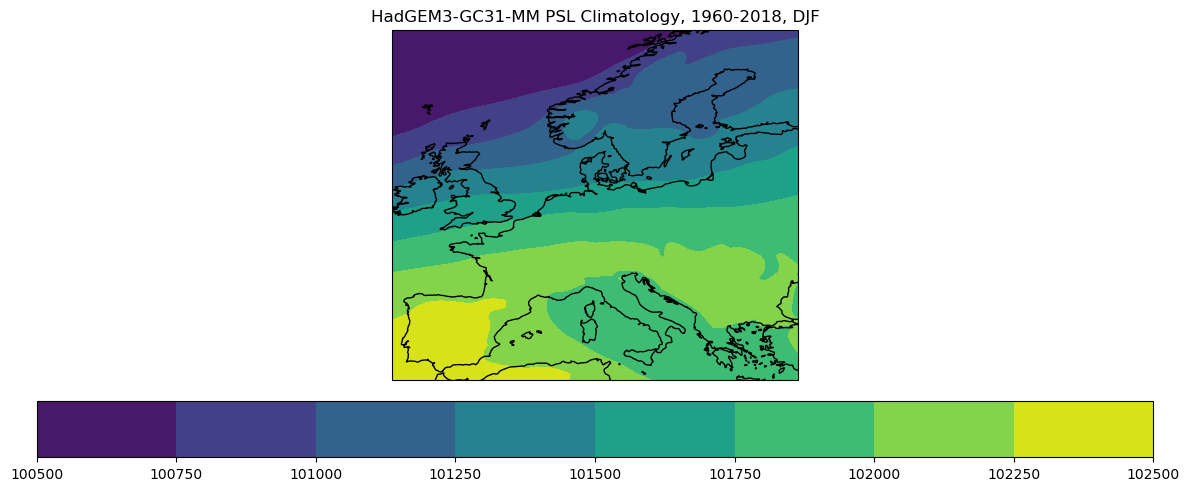

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Extract the lat and lon from the test_arr
lats = np.load("/gws/nopw/j04/canari/users/benhutch/unseen/saved_arrs/metadata/HadGEM3-GC31-MM_tas_Europe_2018_DJF_day_lats.npy")
lons = np.load("/gws/nopw/j04/canari/users/benhutch/unseen/saved_arrs/metadata/HadGEM3-GC31-MM_tas_Europe_2018_DJF_day_lons.npy")

# # Example model_psl_clim array with correct dimensions
# model_psl_clim = np.random.rand(lats.shape[0], lons.shape[1])

# Set up a figure
fig = plt.figure(figsize=(12, 5))

# Plot the psl climatology
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

# Use contourf
contour = ax.contourf(
    lons,
    lats,
    model_psl_clim,
    cmap="viridis",
    transform=ccrs.PlateCarree()
)

# Add coastlines
ax.coastlines()

# Add a colorbar
cbar = plt.colorbar(contour, ax=ax, orientation="horizontal", pad=0.05)

# Add a title
plt.title("HadGEM3-GC31-MM PSL Climatology, 1960-2018, DJF")

# Ensure a tight layout
plt.tight_layout()

# Show the plot
plt.show()

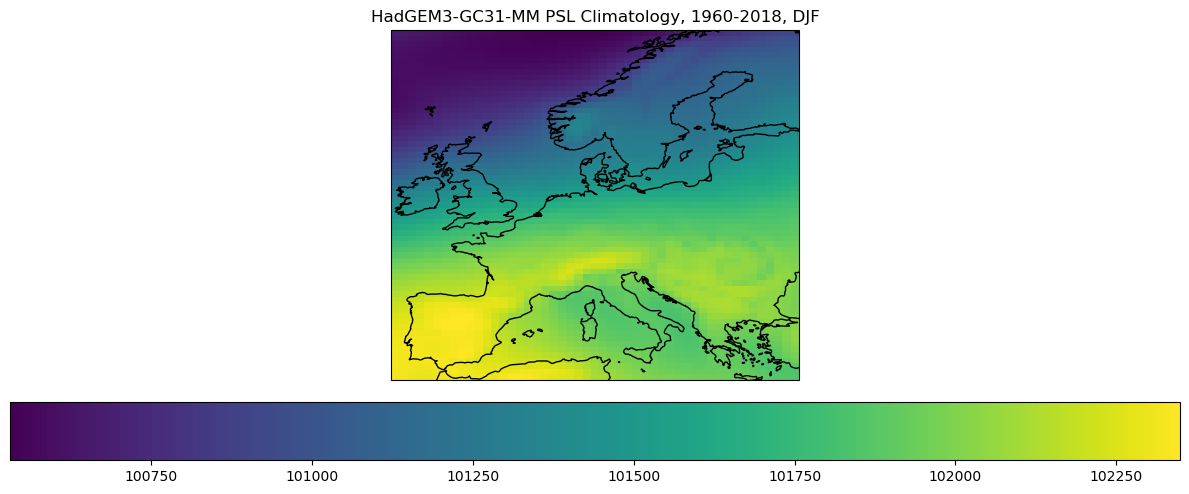

In [25]:
# Set up a figure
fig = plt.figure(figsize=(12, 5))

# Plot the psl climatology
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

# Use pcolormesh
mesh = ax.pcolormesh(
    lons,
    lats,
    model_psl_clim,
    cmap="viridis",
    transform=ccrs.PlateCarree(),
    shading="auto"  # Use shading='auto' to handle the dimensions automatically
)

# Add coastlines
ax.coastlines()

# Add a colorbar
cbar = plt.colorbar(mesh, ax=ax, orientation="horizontal", pad=0.05)

# Add a title
plt.title("HadGEM3-GC31-MM PSL Climatology, 1960-2018, DJF")

# Ensure a tight layout
plt.tight_layout()

# Show the plot
plt.show()

In [32]:
df.tail()

Unnamed: 0  init_year  winter_year  member  data_tas_c_min  lead  \
5815           0       1960           11       6       -6.640927  3700   
5816           0       1960           11       7       -9.403192  3663   
5817           0       1960           11       8       -5.797964  3671   
5818           0       1960           11       9       -1.381277  3636   
5819           0       1960           11      10      -10.363957  3656   

      effective_dec_year  
5815                1970  
5816                1970  
5817                1970  
5818                1970  
5819                1970

In [30]:
# Set up the effective dec year
df["effective_dec_year"] = df["init_year"] + (df["winter_year"] - 1)

In [33]:
member_file = np.load("/gws/nopw/j04/canari/users/benhutch/unseen/saved_arrs/metadata/HadGEM3-GC31-MM_tas_Europe_2017_DJF_day_members.npy")

member_file_2 = np.load("/gws/nopw/j04/canari/users/benhutch/unseen/saved_arrs/metadata/HadGEM3-GC31-MM_tas_Europe_2015_DJF_day_members.npy")

In [34]:
member_file

array(['r10i1p1f2', 'r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2', 'r4i1p1f2',
       'r5i1p1f2', 'r6i1p1f2', 'r7i1p1f2', 'r8i1p1f2', 'r9i1p1f2'],
      dtype='<U9')

In [35]:
member_file_2

array(['r10i1p1f2', 'r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2', 'r4i1p1f2',
       'r5i1p1f2', 'r6i1p1f2', 'r7i1p1f2', 'r8i1p1f2', 'r9i1p1f2'],
      dtype='<U9')

In [44]:
df.head()

init_year  winter_year  member  data_tas_c_min  lead  effective_dec_year
0       1961            1       1       -0.182632    41                1961
1       1961            1       2       -3.340369   117                1961
2       1961            1       3       -8.990547    56                1961
3       1961            1       4       -3.685203    58                1961
4       1961            1       5        1.743228   100                1961

In [41]:
# remove the "Unnamed: 0" column
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [43]:
# reset the index
df = df.reset_index(drop=True)

In [47]:
# ------------------------------------------
# Now we use the df to calculate the anomalies for given decades
# ------------------------------------------

# Set up the members list
members_list = [
    10, 1, 2, 3, 4, 5, 6, 7, 8, 9
]

# Set up the decades
# Set up the decades as a list of arrays
decade_years = [
    np.arange(1961, 1970),
    np.arange(1970, 1980),
    np.arange(1980, 1990),
    np.arange(1990, 2000),
    np.arange(2000, 2010),
    np.arange(2010, 2018)
]

# Set up an empty dictionary to store the anomalies
decade_fields = {}

# Loop over the decades
for decade in tqdm(decade_years, desc="Decades"):
    # Subset the df to the effective dec years in this decade
    df_this_decade = df[df["effective_dec_year"].isin(decade)]

    # Initialise an empty array to store the anomalies
    field_this_decade = np.zeros((len(df_this_decade), model_psl_clim.shape[0], model_psl_clim.shape[1]))

    # reset the index of df_this_decade
    df_this_decade = df_this_decade.reset_index(drop=True)

    # Loop over the rows in df this decade
    for i, row in tqdm(df_this_decade.iterrows(), desc="Rows", total=len(df_this_decade)):
        # Extract the init year and winter year
        init_year = row["init_year"]
        member = row["member"]
        lead = row["lead"]

        # Find the index of the year in model_years
        init_year_idx = np.where(model_years == init_year)[0][0]

        # Find the index of the member in members list
        member_idx = np.where(members_list == member)[0][0]

        # Get the lead idx
        lead_idx = (lead - 1).astype(int)

        # # # print the indices
        # print(init_year_idx, member_idx, lead_idx)
        # print(f"row: {row}, index {i}")

        # Append the anomaly to the field_this_decade array
        field_this_decade[i, :, :] = model_psl_arr[init_year_idx, member_idx, lead_idx, :, :]

    # Store the anomalies in the anomalies dictionary
    decade_fields[str(decade[0])] = field_this_decade

Decades: 100%|██████████| 6/6 [00:00<00:00, 27.24it/s]


In [50]:
first_decade = decade_fields["1961"]

In [51]:
# assert that there are no nans in the first_decade array
assert np.isnan(first_decade).sum() == 0

In [72]:
min_lon = lons.min()

In [73]:
min_lon

np.float64(-10.41668701171875)

In [74]:
max_lon = lons.max()

In [75]:
max_lon

np.float64(29.583332061767578)

In [78]:
# find the max lat
max_lat = lats.max()

# print the max lat
max_lat

np.float64(69.72223663330078)

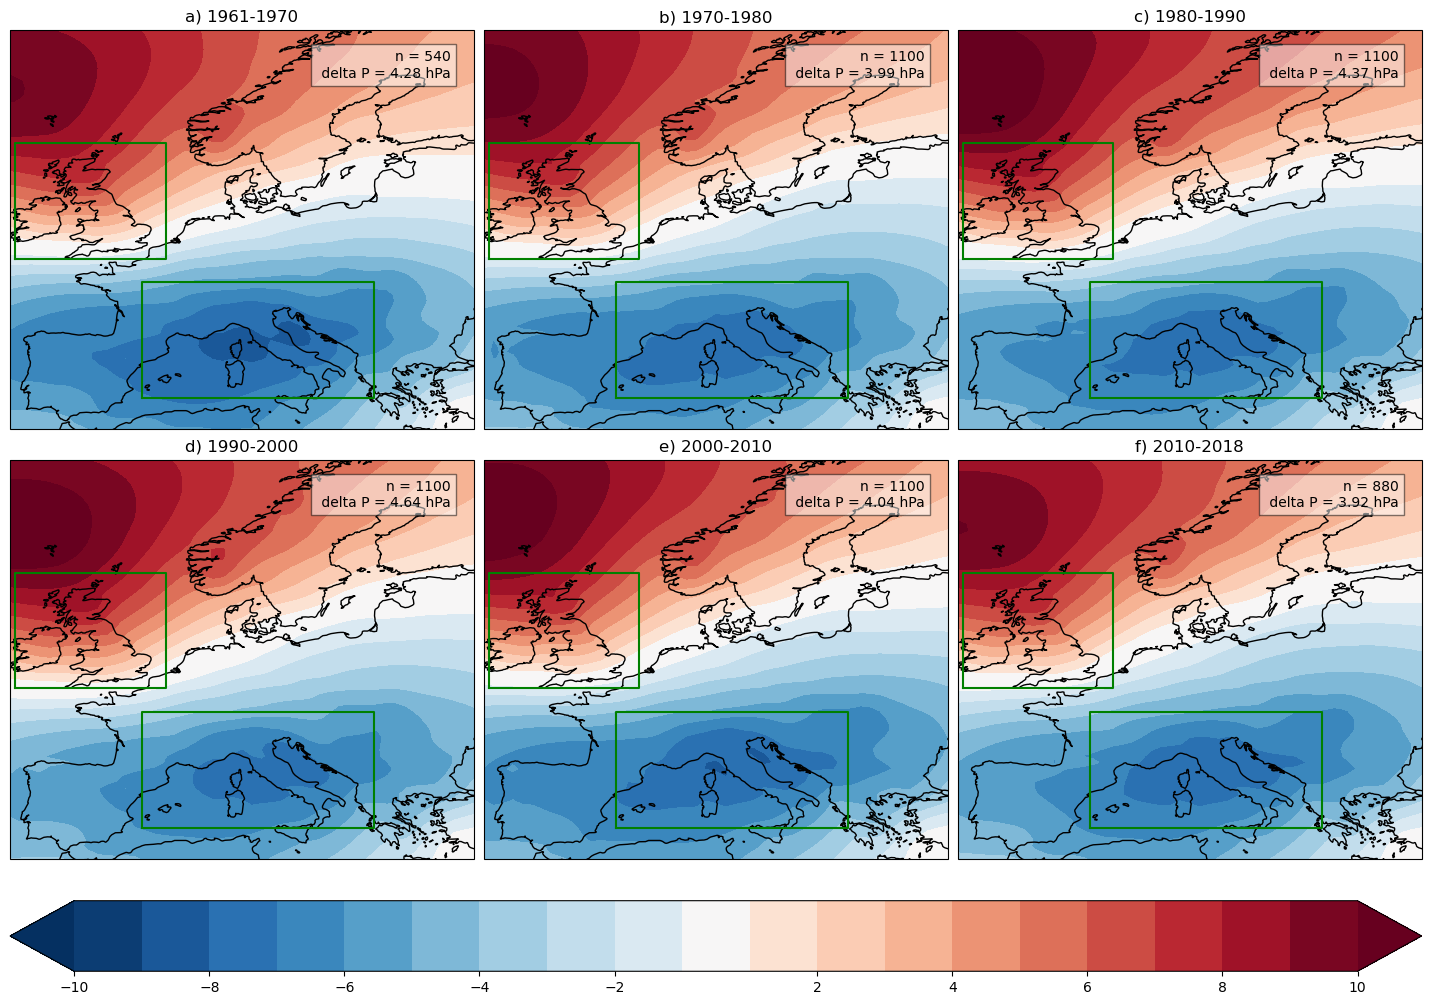

In [84]:
# ------------------------------------------
# Now calculate the anomalies and plot the figure
# ------------------------------------------

# Set up the labels
labels = [
    "a) 1961-1970",
    "b) 1970-1980",
    "c) 1980-1990",
    "d) 1990-2000",
    "e) 2000-2010",
    "f) 2010-2018",
]

# Set up the clevs for pressure
psl_levels = np.array([-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# set up the ticks
psl_ticks = np.array([-10, -8, -6, -4, -2, 2, 4, 6, 8, 10])

# Set up the uk n box
uk_n_box = {
    "lon1": -10,
    "lon2": 21,
    "lat1": 57,
    "lat2": 69,
}

# Set up the UK south box
uk_s_box = {
    "lon1": -10,
    "lon2": 21,
    "lat1": 38,
    "lat2": 51,
}

# new north grid
uk_grid = {
    'lon1': -10,
    'lon2': 3,
    'lat1': 50,
    'lat2': 60
}

# new south grid
med_box = {
    "lon1": 1,
    "lon2": 21,
    "lat1": 38,
    "lat2": 48,
}

# reset the ukn box and south box
uk_n_box = uk_grid
uk_s_box = med_box

# # find the closest lats and lons to the UK boxes
# uk_n_box["lon1_idx"] = np.min(np.abs(lons - uk_n_box["lon1"])).astype(int)

# find the closest lons
lon1_idx_uk_n = np.argmin(np.abs(lons - uk_n_box["lon1"]))
lon2_idx_uk_n = np.argmin(np.abs(lons - uk_n_box["lon2"]))
lat1_idx_uk_n = np.argmin(np.abs(lats - uk_n_box["lat1"]))
lat2_idx_uk_n = np.argmin(np.abs(lats - uk_n_box["lat2"]))

# Do the other ones
lon1_idx_uk_s = np.argmin(np.abs(lons - uk_s_box["lon1"]))
lon2_idx_uk_s = np.argmin(np.abs(lons - uk_s_box["lon2"]))
lat1_idx_uk_s = np.argmin(np.abs(lats - uk_s_box["lat1"]))
lat2_idx_uk_s = np.argmin(np.abs(lats - uk_s_box["lat2"]))

# Set up the figure with 2 rows and 3 columns
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10), subplot_kw={"projection": ccrs.PlateCarree()}, layout="compressed")

# Flatten the axs
axs_flat = axs.flatten()

# Iterate over the decades dictionary and labels and axs
for i, decade in enumerate(decade_fields):
    # Extract the data for the decade
    data_this_decade = decade_fields[decade]

    # Quantify the num_days
    num_days = data_this_decade.shape[0]

    # Set up the contours
    contour = axs_flat[i].contourf(
        lons,
        lats,
        (np.mean(data_this_decade, axis=0) - model_psl_clim) / 100,
        cmap="RdBu_r",
        levels=psl_levels,
        extend="both"
    )

    # Add coastlines
    axs_flat[i].coastlines()

    # add the title
    axs_flat[i].set_title(labels[i])

    # plot the outline of the UK north box in green
    axs_flat[i].plot(
        [uk_n_box["lon1"], uk_n_box["lon1"], uk_n_box["lon2"], uk_n_box["lon2"], uk_n_box["lon1"]],
        [uk_n_box["lat1"], uk_n_box["lat2"], uk_n_box["lat2"], uk_n_box["lat1"], uk_n_box["lat1"]],
        color="green",
        transform=ccrs.PlateCarree()
    )

    # Plot the outline of the UK south box in green
    axs_flat[i].plot(
        [uk_s_box["lon1"], uk_s_box["lon1"], uk_s_box["lon2"], uk_s_box["lon2"], uk_s_box["lon1"]],
        [uk_s_box["lat1"], uk_s_box["lat2"], uk_s_box["lat2"], uk_s_box["lat1"], uk_s_box["lat1"]],
        color="green",
        transform=ccrs.PlateCarree()
    )

    # calculate the pressure difference
    n_box = np.mean(data_this_decade[:, lat1_idx_uk_n:lat2_idx_uk_n, lon1_idx_uk_n:lon2_idx_uk_n], axis=0)
    s_box = np.mean(data_this_decade[:, lat1_idx_uk_s:lat2_idx_uk_s, lon1_idx_uk_s:lon2_idx_uk_s], axis=0)

    # calculate the pressure difference
    p_diff = (np.mean(n_box) - np.mean(s_box)) / 100

    # Include the num days in a textbox in the top right
    axs_flat[i].text(
        0.95,
        0.95,
        f"n = {num_days}\n delta P = {p_diff:.2f} hPa",
        verticalalignment="top",
        horizontalalignment="right",
        transform=axs_flat[i].transAxes,
        fontsize=10,
        bbox=dict(facecolor="white", alpha=0.5)
    )

# Add a colorbar
cbar = plt.colorbar(contour, ax=axs_flat, orientation="horizontal", pad=0.05)

# Set up the ticks for the cbar
cbar.set_ticks(psl_ticks)

Decade: 1961
Mean: 101507.80
Min: 95631.06
Max: 106477.62
Decade: 1970
Mean: 101521.58
Min: 96072.81
Max: 106305.88
Decade: 1980
Mean: 101551.14
Min: 95670.50
Max: 106036.56
Decade: 1990
Mean: 101558.77
Min: 95532.44
Max: 106425.12
Decade: 2000
Mean: 101509.98
Min: 95910.25
Max: 106551.88
Decade: 2010
Mean: 101507.40
Min: 96595.69
Max: 106242.81


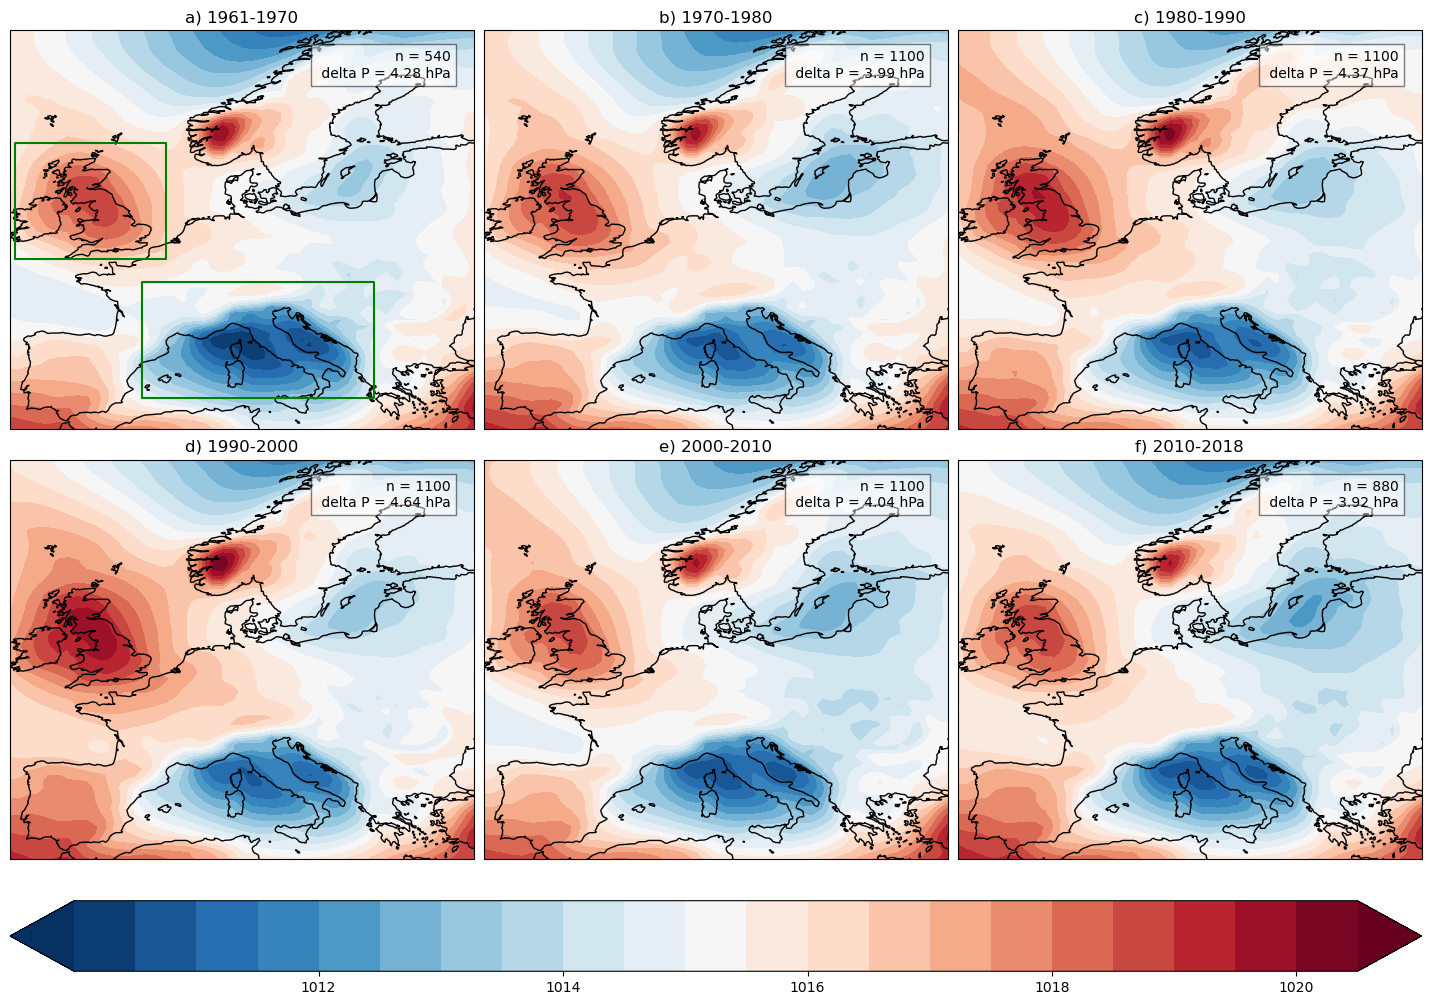

In [85]:
# ------------------------------------------
# Now repea the same plot, but in full field form
# ------------------------------------------

# # loop through the dictionary and print the mean, min and max
for decade in decade_fields:
    # Extract the data for the decade
    data_this_decade = decade_fields[decade]

    # print the mean, min and max
    print(f"Decade: {decade}")
    print(f"Mean: {np.mean(data_this_decade):.2f}")
    print(f"Min: {np.min(data_this_decade):.2f}")
    print(f"Max: {np.max(data_this_decade):.2f}")

# Set up the psl_abs_clevs
psl_abs_clevs = np.array(np.arange(1010, 1020 + 1, 0.5))

# Set up the ticks
psl_abs_ticks = np.array([1012, 1014, 1016, 1018, 1020])

# Set up the figure with 2 rows and 3 columns
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10), subplot_kw={"projection": ccrs.PlateCarree()}, layout="compressed")

# Flatten the axs
axs_flat = axs.flatten()

# Iterate over the decades dictionary and labels and axs
for i, decade in enumerate(decade_fields):
    # Extract the data for the decade
    data_this_decade = decade_fields[decade]

    # Quantify the num_days
    num_days = data_this_decade.shape[0]

    # Set up the contours
    contour = axs_flat[i].contourf(
        lons,
        lats,
        np.mean(data_this_decade, axis=0) / 100,
        cmap="RdBu_r",
        levels=psl_abs_clevs,
        extend="both"
    )

    # Add coastlines
    axs_flat[i].coastlines()

    # add the title
    axs_flat[i].set_title(labels[i])

    if i == 0:
        # plot the outline of the UK north box in green
        axs_flat[i].plot(
            [uk_n_box["lon1"], uk_n_box["lon1"], uk_n_box["lon2"], uk_n_box["lon2"], uk_n_box["lon1"]],
            [uk_n_box["lat1"], uk_n_box["lat2"], uk_n_box["lat2"], uk_n_box["lat1"], uk_n_box["lat1"]],
            color="green",
            transform=ccrs.PlateCarree()
        )

        # Plot the outline of the UK south box in green
        axs_flat[i].plot(
            [uk_s_box["lon1"], uk_s_box["lon1"], uk_s_box["lon2"], uk_s_box["lon2"], uk_s_box["lon1"]],
            [uk_s_box["lat1"], uk_s_box["lat2"], uk_s_box["lat2"], uk_s_box["lat1"], uk_s_box["lat1"]],
            color="green",
            transform=ccrs.PlateCarree()
        )

    # Calculate the pressure difference
    n_box = np.mean(data_this_decade[:, lat1_idx_uk_n:lat2_idx_uk_n, lon1_idx_uk_n:lon2_idx_uk_n], axis=0)
    s_box = np.mean(data_this_decade[:, lat1_idx_uk_s:lat2_idx_uk_s, lon1_idx_uk_s:lon2_idx_uk_s], axis=0)

    # calculate the pressure difference
    p_diff = (np.mean(n_box) - np.mean(s_box)) / 100

    # Include the num days in a textbox in the top right
    axs_flat[i].text(
        0.95,
        0.95,
        f"n = {num_days}\n delta P = {p_diff:.2f} hPa",
        verticalalignment="top",
        horizontalalignment="right",
        transform=axs_flat[i].transAxes,
        fontsize=10,
        bbox=dict(facecolor="white", alpha=0.5)
    )

# Add a colorbar
cbar = plt.colorbar(contour, ax=axs_flat, orientation="horizontal", pad=0.05)

# Set up the ticks for the cbar
cbar.set_ticks(psl_abs_ticks)


In [87]:
model_psl_arr_winters.shape

(59, 10, 1001, 63, 49)

In [111]:
model_psl_clim.shape

(63, 49)

Text(0.5, 1.0, 'UK North - UK South PSL difference, 1960-2018')

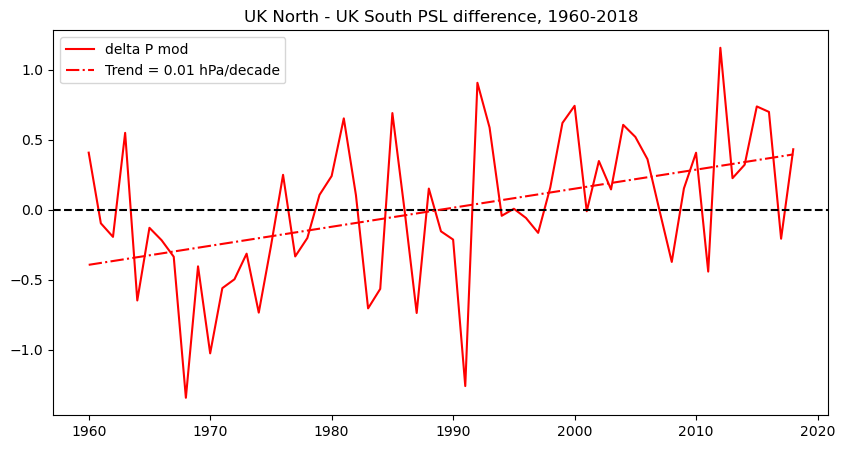

In [94]:
# ------------------------------------------
# Plot a time series of the modified delta P index for the whole period
# ------------------------------------------

model_psl_arr_all_winters_ensmean = np.mean(model_psl_arr_winters, axis=(1, 2))

# Set up the UK boxes
# Set up the uk n box
uk_n_box = {
    "lon1": -10,
    "lon2": 21,
    "lat1": 57,
    "lat2": 69,
}

# Set up the UK south box
uk_s_box = {
    "lon1": -10,
    "lon2": 21,
    "lat1": 38,
    "lat2": 51,
}

# # find the closest lats and lons to the UK boxes
# uk_n_box["lon1_idx"] = np.min(np.abs(lons - uk_n_box["lon1"])).astype(int)

# find the closest lons
lon1_idx_uk_n = np.argmin(np.abs(lons - uk_n_box["lon1"]))
lon2_idx_uk_n = np.argmin(np.abs(lons - uk_n_box["lon2"]))
lat1_idx_uk_n = np.argmin(np.abs(lats - uk_n_box["lat1"]))
lat2_idx_uk_n = np.argmin(np.abs(lats - uk_n_box["lat2"]))

# Do the other ones
lon1_idx_uk_s = np.argmin(np.abs(lons - uk_s_box["lon1"]))
lon2_idx_uk_s = np.argmin(np.abs(lons - uk_s_box["lon2"]))
lat1_idx_uk_s = np.argmin(np.abs(lats - uk_s_box["lat1"]))
lat2_idx_uk_s = np.argmin(np.abs(lats - uk_s_box["lat2"]))

uk_n_ts_anoms = np.mean(model_psl_arr_all_winters_ensmean[:, lat1_idx_uk_n:lat2_idx_uk_n, lon1_idx_uk_n:lon2_idx_uk_n], axis=(1, 2)) - np.mean(model_psl_clim[lat1_idx_uk_n:lat2_idx_uk_n, lon1_idx_uk_n:lon2_idx_uk_n], axis=(0, 1))
uk_s_ts_anoms = np.mean(model_psl_arr_all_winters_ensmean[:, lat1_idx_uk_s:lat2_idx_uk_s, lon1_idx_uk_s:lon2_idx_uk_s], axis=(1, 2)) - np.mean(model_psl_clim[lat1_idx_uk_s:lat2_idx_uk_s, lon1_idx_uk_s:lon2_idx_uk_s], axis=(0, 1))

# uk_n_ts = np.mean(model_psl_arr_all_winters_ensmean[:, lat1_idx_uk_n:lat2_idx_uk_n, lon1_idx_uk_n:lon2_idx_uk_n], axis=(1, 2))
# uk_s_ts = np.mean(model_psl_arr_all_winters_ensmean[:, lat1_idx_uk_s:lat2_idx_uk_s, lon1_idx_uk_s:lon2_idx_uk_s], axis=(1, 2))

# # Calculate the pressure difference
# p_diff = uk_n_ts - uk_s_ts

# calculate the pressure difference anoms
p_diff_anoms = uk_n_ts_anoms - uk_s_ts_anoms

# Set up the figure
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the pressure difference
ax.plot(model_years, p_diff_anoms / 100, color="red", label="delta P mod")

# Add a horizontal line at 0
ax.axhline(0, color="black", linestyle="--")

# fit a straight line to the data
m, c = np.polyfit(model_years, p_diff_anoms / 100, 1)

# Add the linear trend to the plot
ax.plot(model_years, m * model_years + c, color="red", linestyle="-.", label=f"Trend = {m:.2f} hPa/decade")

# Add a legend
ax.legend()

# Add a title
ax.set_title("UK North - UK South PSL difference, 1960-2018")

In [95]:
%%time
# ------------------------------------------
# Import the psl from the obs to see whether the same thing is happening
# ------------------------------------------

obs_path = (
    "/gws/nopw/j04/canari/users/benhutch/ERA5/ERA5_msl_daily_1960_2020_daymean.nc"
)

# Load the data
obs_data = iris.load_cube(obs_path, "msl")

CPU times: user 169 ms, sys: 355 ms, total: 525 ms
Wall time: 22.5 s


In [97]:
# ------------------------------------------
# Process the obs data
# ------------------------------------------

# Constrain the cube to D, J, F
obs_data_djf = obs_data.extract(iris.Constraint(time=lambda cell: cell.point.month in [12, 1, 2]))

# Subset to the northern and southern UK boxes
obs_data_djf_n = obs_data_djf.intersection(
    longitude=(uk_n_box["lon1"], uk_n_box["lon2"]),
    latitude=(uk_n_box["lat1"], uk_n_box["lat2"]),
)

obs_data_djf_s = obs_data_djf.intersection(
    longitude=(uk_s_box["lon1"], uk_s_box["lon2"]),
    latitude=(uk_s_box["lat1"], uk_s_box["lat2"]),
)

In [101]:
# ------------------------------------------
# Further processing of obs data
# ------------------------------------------

# Calculate the climatology for the boxes
obs_data_djf_n_clim = obs_data_djf_n.collapsed("time", iris.analysis.MEAN)
obs_data_djf_s_clim = obs_data_djf_s.collapsed("time", iris.analysis.MEAN)

# Calculate the anomalies
obs_data_djf_n_anoms = obs_data_djf_n - obs_data_djf_n_clim
obs_data_djf_s_anoms = obs_data_djf_s - obs_data_djf_s_clim

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2182: IrisVagueMetadataWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(


In [104]:
# ------------------------------------------
# Group these by season
# ------------------------------------------

import iris.coord_categorisation

iris.coord_categorisation.add_season(obs_data_djf_n_anoms, "time", name="clim_season")
iris.coord_categorisation.add_season(obs_data_djf_s_anoms, "time", name="clim_season")

# ------------------------------------------
# same for the season year
# ------------------------------------------
iris.coord_categorisation.add_season_year(obs_data_djf_n_anoms, "time", name="season_year")
iris.coord_categorisation.add_season_year(obs_data_djf_s_anoms, "time", name="season_year")

# ------------------------------------------
# Now aggregate by clim season and season year and take the mean
# ------------------------------------------

# Aggregate by clim season and season year
obs_data_djf_n_anoms_seasonal = obs_data_djf_n_anoms.aggregated_by(["clim_season", "season_year"], iris.analysis.MEAN)
obs_data_djf_s_anoms_seasonal = obs_data_djf_s_anoms.aggregated_by(["clim_season", "season_year"], iris.analysis.MEAN)

In [106]:
%%time
# ------------------------------------------
# Now take the spatial mean and extract the values
# ------------------------------------------

obs_p_diff = obs_data_djf_n_anoms_seasonal.collapsed(["latitude", "longitude"], iris.analysis.MEAN) - obs_data_djf_s_anoms_seasonal.collapsed(["latitude", "longitude"], iris.analysis.MEAN)

# Extract the data
obs_p_diff_data = obs_p_diff.data

# extract the years
obs_p_diff_years = obs_p_diff.coord("season_year").points

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/cube.py:4330: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'latitude', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'latitude'. Ignoring bounds.
  warnings.warn(
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'longitude', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'longitude'. Ignoring bounds.
  warnings.warn(


CPU times: user 2.45 s, sys: 8.62 s, total: 11.1 s
Wall time: 12 s


In [110]:
# process south - north instead
obs_p_diff_rev = obs_data_djf_s_anoms_seasonal.collapsed(["latitude", "longitude"], iris.analysis.MEAN) - obs_data_djf_n_anoms_seasonal.collapsed(["latitude", "longitude"], iris.analysis.MEAN)

# extract the data
obs_p_diff_rev_data = obs_p_diff_rev.data

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/cube.py:4330: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'latitude', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'latitude'. Ignoring bounds.
  warnings.warn(
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'longitude', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'longitude'. Ignoring bounds.
  warnings.warn(
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/pytho

In [112]:
# do the same for the model data
model_p_diff_rev = uk_s_ts_anoms - uk_n_ts_anoms

In [108]:
obs_p_diff_years

array([1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020, 2021])

Text(0.5, 1.0, 'UK South - UK North PSL difference, 1960-2018')

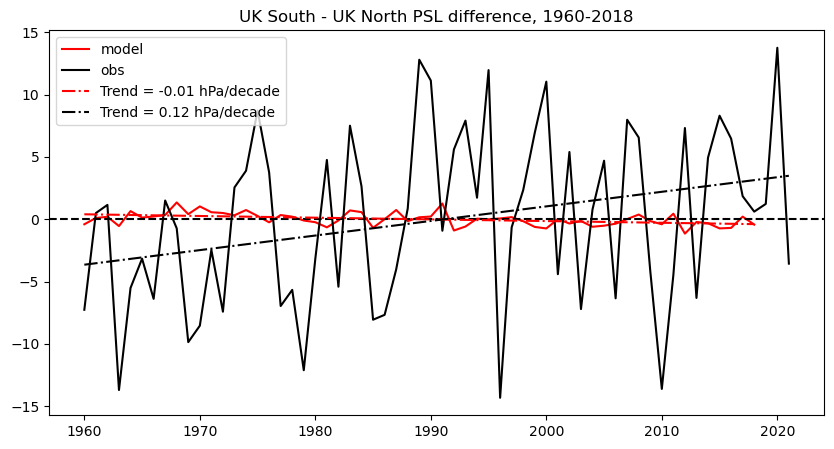

In [113]:
# Set up the figure
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the pressure difference
ax.plot(model_years, model_p_diff_rev / 100, color="red", label="model")

# plot the obs diff in black
ax.plot(obs_p_diff_years, obs_p_diff_rev_data / 100, color="black", label="obs")

# Add a horizontal line at 0
ax.axhline(0, color="black", linestyle="--")

# fit a straight line to the data
m, c = np.polyfit(model_years, model_p_diff_rev / 100, 1)

# Add the linear trend to the plot
ax.plot(model_years, m * model_years + c, color="red", linestyle="-.", label=f"Trend = {m:.2f} hPa/decade")

# fit a straight line to the obs data
m_obs, c_obs = np.polyfit(obs_p_diff_years, obs_p_diff_rev_data / 100, 1)

# Add the linear trend to the plot
ax.plot(obs_p_diff_years, m_obs * obs_p_diff_years + c_obs, color="black", linestyle="-.", label=f"Trend = {m_obs:.2f} hPa/decade")

# Add a legend
ax.legend()

# Add a title
ax.set_title("UK South - UK North PSL difference, 1960-2018")

In [121]:
df.head()

init_year  winter_year  member  data_tas_c_min  lead  effective_dec_year
0       1961            1       1       -0.182632    41                1961
1       1961            1       2       -3.340369   117                1961
2       1961            1       3       -8.990547    56                1961
3       1961            1       4       -3.685203    58                1961
4       1961            1       5        1.743228   100                1961

In [126]:
# ------------------------------------------
# Group by effective dec year and calculate the mean delta P
# For the block minima T days
# To identify whether a trend exists
# ------------------------------------------

# Set up the winter years
full_years = np.arange(1961, 2017 + 1, 1)

# Set up an empty array to append to
delta_p_arr = np.zeros((len(full_years)))

# Loop over the full years
for i, year_this in enumerate(full_years):
    # Subset the df to the year
    df_this_year = df[df["effective_dec_year"] == year_this]

    # find the 10th percentile of the block minima T
    tenth_percentile = np.percentile(df_this_year["data_tas_c_min"], 10)

    # Subset the df to the 10th percentile
    df_this_year = df_this_year[df_this_year["data_tas_c_min"] <= tenth_percentile]

    # Reset the index
    df_this_year = df_this_year.reset_index(drop=True)

    # Create an array to store the pressure differences
    arr_values_this_year = np.zeros((len(df_this_year)))

    # print the shape of arr_values_this_year
    print(arr_values_this_year.shape)

    # print the head of the df
    print(df_this_year.head())

    # sys.exit()

    # loop over the rows
    for j, row in df_this_year.iterrows():
        # Extract the init year and winter year
        init_year = row["init_year"]
        member = row["member"]
        lead = row["lead"]

        # Find the index of the year in model_years
        init_year_idx = np.where(model_years == init_year)[0][0]

        # Find the index of the member in members list
        member_idx = np.where(members_list == member)[0][0]

        # Get the lead idx
        lead_idx = (lead - 1).astype(int)

        # Extract the data
        n_box = model_psl_arr[init_year_idx, member_idx, lead_idx, lat1_idx_uk_n:lat2_idx_uk_n, lon1_idx_uk_n:lon2_idx_uk_n]
        s_box = model_psl_arr[init_year_idx, member_idx, lead_idx, lat1_idx_uk_s:lat2_idx_uk_s, lon1_idx_uk_s:lon2_idx_uk_s]

        # Calculate the pressure difference
        # NOTE: South - North for consistency with NAO index
        p_diff = (np.mean(s_box) - np.mean(n_box)) / 100

        # Append to the delta_p_arr
        arr_values_this_year[j] = p_diff

    # print the shape of arr_values_this_year
    print(arr_values_this_year.shape)

    # Calculate the mean delta P for this year
    delta_p_arr[i] = np.mean(arr_values_this_year)

(2,)
   init_year  winter_year  member  data_tas_c_min  lead  effective_dec_year
0       1961            1       3       -8.990547    56                1961
1       1960            2       2      -11.195730   447                1961
(2,)
(3,)
   init_year  winter_year  member  data_tas_c_min  lead  effective_dec_year
0       1961            2       2       -6.385675   461                1962
1       1960            3       1       -5.668504   807                1962
2       1960            3       6       -5.571613   767                1962
(3,)
(4,)
   init_year  winter_year  member  data_tas_c_min  lead  effective_dec_year
0       1961            3       5       -6.090645   793                1963
1       1961            3       7       -5.629270   808                1963
2       1961            3      10       -6.989995   778                1963
3       1960            4       2      -10.364664  1152                1963
(4,)
(5,)
   init_year  winter_year  member  data_tas_c_min  le

In [127]:
delta_p_arr

array([ -6.48770047,  -5.13686786,   2.67587653,  -5.79597012,
         0.1171795 ,  -2.60585619,  -1.01885457, -11.08604743,
        -1.47883837,  -2.38952018,  -3.47266652,  -1.11236822,
        -2.1334547 ,   1.04783156,  -2.02957941,  -2.08447057,
         0.07137552,  -3.6724228 ,   0.36896413,  -1.22025868,
        -5.26441949,  -0.10660536,  -0.01547478,  -4.34079011,
        -1.8951155 ,  -0.94895549,  -0.35760599,  -6.34203183,
        -6.46773097,  -7.31497395,  -0.24844927,  -2.708547  ,
        -1.90275257,  -3.65695665,  -1.01819009,  -1.27153676,
        -0.95938099,  -0.99061333,  -6.35642461,  -5.54549007,
        -5.89333804,  -6.93349663,   0.53034769,  -2.48487031,
        -3.64032821,  -1.87340069,   1.3942358 ,  -1.68727116,
         1.41243461,  -3.30374235,  -5.25526921,  -3.1319371 ,
         0.61469881,  -0.28599303,  -4.41865989,  -0.23969869,
         0.9064268 ])

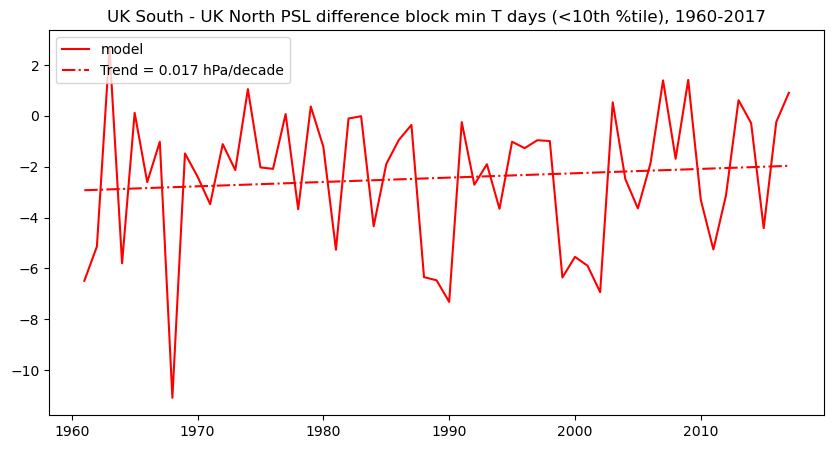

In [128]:
# Set up a figure
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the pressure difference
ax.plot(full_years, delta_p_arr, color="red", label="model")

# Quantify the trend
m, c = np.polyfit(full_years, delta_p_arr, 1)

# Add the linear trend to the plot
ax.plot(full_years, m * full_years + c, color="red", linestyle="-.", label=f"Trend = {m:.3f} hPa/decade")

# Set up the title
ax.set_title("UK South - UK North PSL difference block min T days (<10th %tile), 1960-2017")

# Add a legend
ax.legend(loc="upper left")


In [129]:
# ------------------------------------------
# Load the red dots
# ------------------------------------------

# Set up the path
path_df = "/home/users/benhutch/unseen_multi_year/dfs/block_minima_model_tas_lead_dt_bc_UK_1960-2017_DJF.csv"

# Load the dataframe
df_red = pd.read_csv(path_df)

In [130]:
df_red

Unnamed: 0  init_year  winter_year  member  data_tas_c_min  lead  \
0            0       1961            1       3       -8.990547    56   
1            1       1986            1       8       -6.935892    85   
2            2       1970            2       1       -8.832334   422   
3            3       1972            2       8       -8.968463   422   
4            4       1976            2       1       -8.539426   445   
..         ...        ...          ...     ...             ...   ...   
69          69       1996           11       5       -8.362234  3684   
70          70       2002           11       3       -7.901709  3674   
71          71       1960           11       1      -11.161564  3695   
72          72       1960           11       7       -9.403192  3663   
73          73       1960           11      10      -10.363957  3656   

   effective_dec_year  data_tas_c_min_dt  data_tas_c_min_dt_bc  
0          1961-01-01          -7.249391             -7.139642  
1          1986-01-01          -5.972038             -5.862289  
2          1971-01-01          -9.238992             -6.216893  
3          1973-01-01          -9.456454             -6.434355  
4          1977-01-01          -9.190080             -6.167980  
..                ...                ...                   ...  
69         2006-01-01         -10.215007             -6.396092  
70         2012-01-01         -10.063278             -6.244363  
71         1970-01-01         -11.161564             -7.342649  
72         1970-01-01          -9.403192             -5.584277  
73         1970-01-01         -10.363957             -6.545042  

[74 rows x 9 columns]

In [133]:
# Correctly define the shape tuple for np.zeros
red_dots_arr = np.zeros((len(df_red), np.shape(model_psl_arr)[3], np.shape(model_psl_arr)[4]))

# Print the shape of this array
print(red_dots_arr.shape)

(74, 63, 49)


In [135]:
members_list

[10, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [136]:
model_years

array([1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018])

In [141]:
# Esnure that members list is an array
members_list = np.array(members_list)

tuples_list = []

# Loop over the rows in the red dots df
for i, row in df_red.iterrows():
    # Extract the init year and winter year
    init_year = row["init_year"]
    member = row["member"]
    lead = row["lead"]

    # print the init year and member and lead
    print(init_year, member, lead)

    # Find the index of the year in model_years
    init_year_idx = np.where(model_years == init_year)[0][0]

    # Find the index of the member in members list
    member_idx = np.where(members_list == member)[0][0]

    # Get the lead idx
    lead_idx = int(lead - 1)

    # Save the indices as a tuple
    tuples_list.append((init_year_idx, member_idx, lead_idx))

    # Extract the data
    red_dots_arr[i, :, :] = model_psl_arr[init_year_idx, member_idx, lead_idx, :, :]

1961 3 56
1986 8 85
1970 1 422
1972 8 422
1976 1 445
1991 1 459
1992 3 433
1960 2 447
1963 2 792
1967 5 767
1979 7 802
1980 9 785
1990 3 799
1991 2 787
1965 9 1141
1968 6 1182
1971 2 1152
1972 5 1163
1972 7 1154
1973 10 1156
1981 2 1148
1988 4 1159
1999 5 1150
1960 2 1152
1962 4 1494
1966 2 1527
1971 3 1526
1972 2 1516
1976 1 1531
1977 9 1483
1978 5 1520
1980 7 1537
1983 4 1507
1988 6 1490
1990 6 1523
1967 4 1886
1969 3 1888
1969 10 1894
1970 10 1851
1972 5 1868
1976 9 1853
1985 8 1876
1999 6 1873
2007 9 1854
1965 2 2253
1967 4 2225
1975 8 2229
1981 4 2260
1988 9 2256
1965 8 2599
1979 3 2594
1990 1 2579
1962 10 2950
1963 3 2936
1968 6 2957
1969 2 2935
1979 9 2931
1998 9 2946
1965 8 3300
1965 10 3316
1976 1 3314
1982 2 3312
1988 2 3310
1963 9 3683
1966 2 3673
1970 3 3697
1985 3 3652
1992 1 3660
1993 2 3683
1996 5 3684
2002 3 3674
1960 1 3695
1960 7 3663
1960 10 3656


In [149]:
len(red_dots_arr)

74

In [142]:
tuples_list

[(np.int64(1), np.int64(3), 55),
 (np.int64(26), np.int64(8), 84),
 (np.int64(10), np.int64(1), 421),
 (np.int64(12), np.int64(8), 421),
 (np.int64(16), np.int64(1), 444),
 (np.int64(31), np.int64(1), 458),
 (np.int64(32), np.int64(3), 432),
 (np.int64(0), np.int64(2), 446),
 (np.int64(3), np.int64(2), 791),
 (np.int64(7), np.int64(5), 766),
 (np.int64(19), np.int64(7), 801),
 (np.int64(20), np.int64(9), 784),
 (np.int64(30), np.int64(3), 798),
 (np.int64(31), np.int64(2), 786),
 (np.int64(5), np.int64(9), 1140),
 (np.int64(8), np.int64(6), 1181),
 (np.int64(11), np.int64(2), 1151),
 (np.int64(12), np.int64(5), 1162),
 (np.int64(12), np.int64(7), 1153),
 (np.int64(13), np.int64(0), 1155),
 (np.int64(21), np.int64(2), 1147),
 (np.int64(28), np.int64(4), 1158),
 (np.int64(39), np.int64(5), 1149),
 (np.int64(0), np.int64(2), 1151),
 (np.int64(2), np.int64(4), 1493),
 (np.int64(6), np.int64(2), 1526),
 (np.int64(11), np.int64(3), 1525),
 (np.int64(12), np.int64(2), 1515),
 (np.int64(16), n

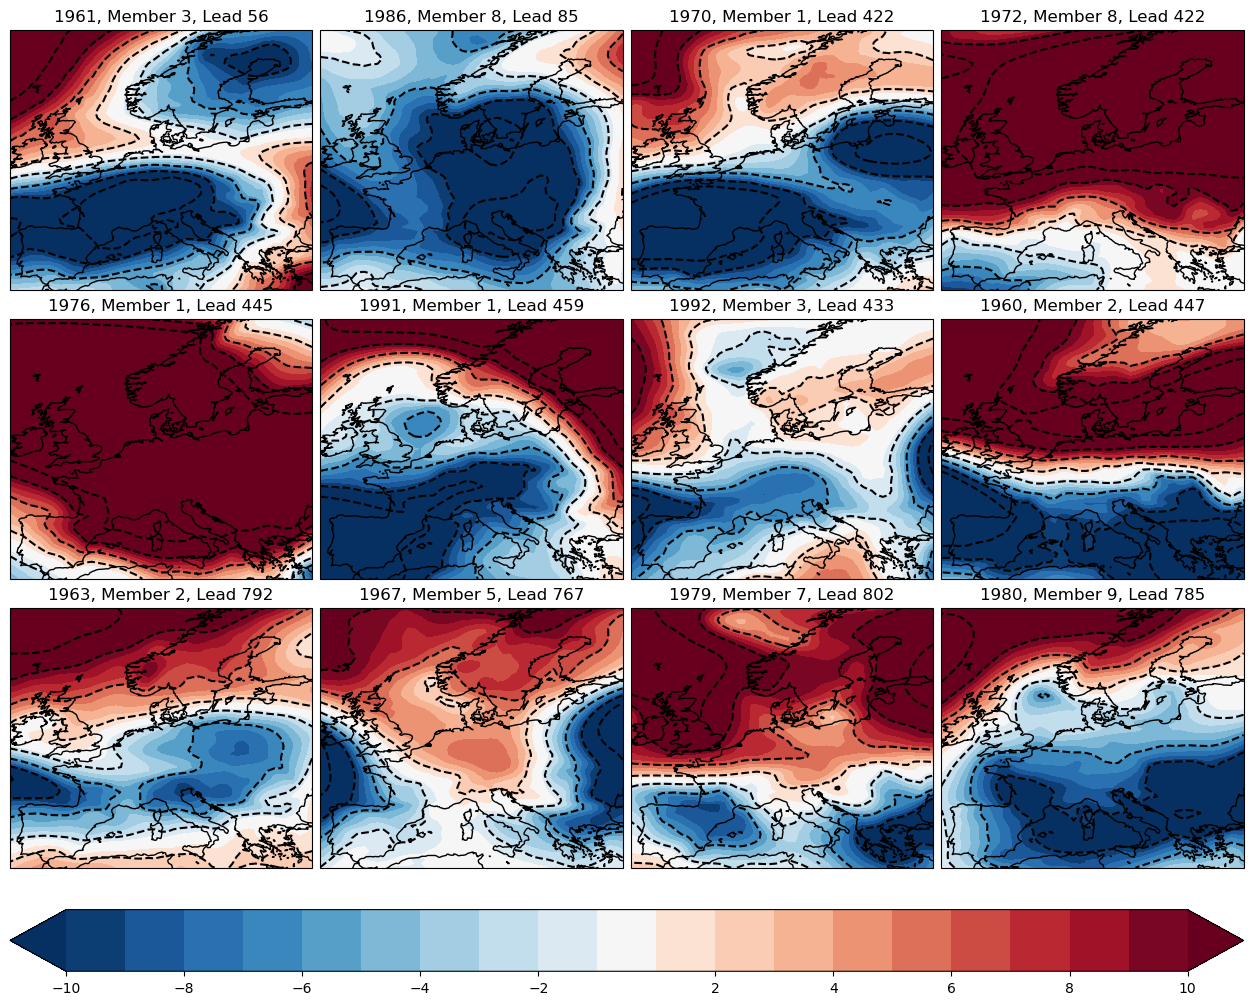

In [151]:
# ------------------------------------------
# Plot the anomalies for the first 12 events
# ------------------------------------------

# set up the ticks
psl_ticks = np.array([-10, -8, -6, -4, -2, 2, 4, 6, 8, 10])

psl_levels_contours = np.array([-14, -10, -6, -2, 2, 6, 10, 14])

# Set up a plot with 3 rows and 4 columns
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15, 10), subplot_kw={"projection": ccrs.PlateCarree()}, layout="compressed")

# Flatten the axs
axs_flat = axs.flatten()

first_dozen_arr = red_dots_arr[0:12, :, :]
first_dozen_tuples = tuples_list[0:12]

second_dozen_arr = red_dots_arr[12:24, :, :]
second_dozen_tuples = tuples_list[12:24]

third_dozen_arr = red_dots_arr[24:36, :, :]
third_dozen_tuples = tuples_list[24:36]

fourth_dozen_arr = red_dots_arr[36:48, :, :]
fourth_dozen_tuples = tuples_list[36:48]

fifth_dozen_arr = red_dots_arr[48:60, :, :]
fifth_dozen_tuples = tuples_list[48:60]

sixth_dozen_arr = red_dots_arr[60:72, :, :]
sixth_dozen_tuples = tuples_list[60:72]

seventh_dozen_arr = red_dots_arr[72:84, :, :]
seventh_dozen_tuples = tuples_list[72:84]

# Loop over the first dozen
for i, arr_this in enumerate(first_dozen_arr):
    # Extract the tuple
    tuple_this = first_dozen_tuples[i]

    # Extract the init year, member and lead
    init_year = model_years[tuple_this[0]]
    member = members_list[tuple_this[1]]
    lead = tuple_this[2] + 1

    # Set up the title
    title = f"{init_year}, Member {member}, Lead {lead}"

    # Plot the data
    contour = axs_flat[i].contourf(
        lons,
        lats,
        (arr_this - model_psl_clim) / 100,
        cmap="RdBu_r",
        levels=psl_levels,
        extend="both"
    )

    # include contours
    axs_flat[i].contour(
        lons,
        lats,
        (arr_this - model_psl_clim) / 100,
        levels=psl_levels_contours,
        colors="black",
        linestyles="dashed"
    )

    # Add coastlines
    axs_flat[i].coastlines()

    # Add the title
    axs_flat[i].set_title(title)

# Add a colorbar
cbar = plt.colorbar(contour, ax=axs_flat, orientation="horizontal", pad=0.05)

# Set up the ticks for the cbar
cbar.set_ticks(psl_ticks)

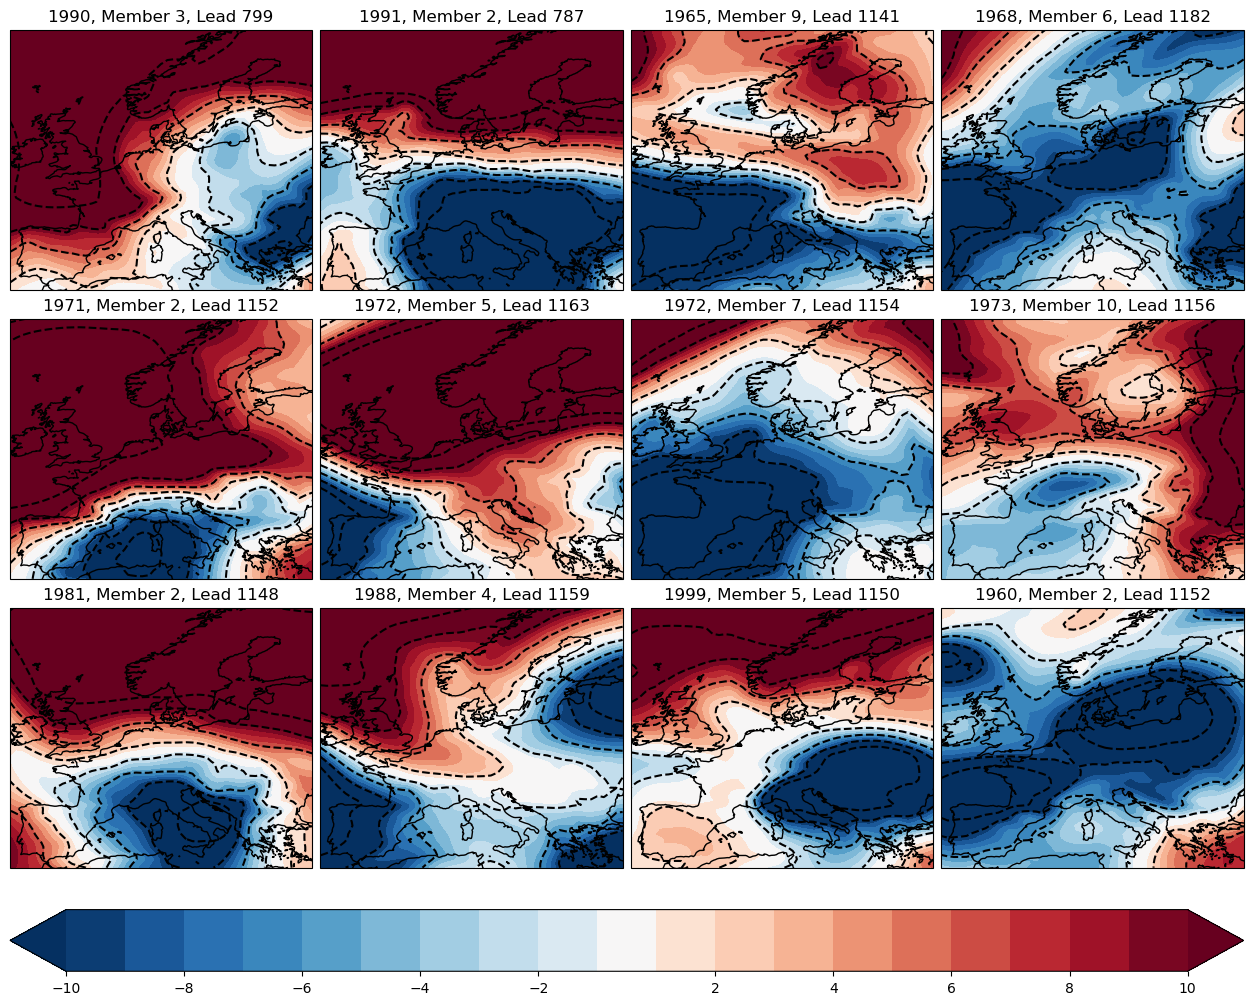

In [154]:
# Set up a plot with 3 rows and 4 columns
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15, 10), subplot_kw={"projection": ccrs.PlateCarree()}, layout="compressed")

# flatten the axs
axs_flat = axs.flatten()

# Loop over the first dozen
for i, arr_this in enumerate(second_dozen_arr):
    # Extract the tuple
    tuple_this = second_dozen_tuples[i]

    # Extract the init year, member and lead
    init_year = model_years[tuple_this[0]]
    member = members_list[tuple_this[1]]
    lead = tuple_this[2] + 1

    # Set up the title
    title = f"{init_year}, Member {member}, Lead {lead}"

    # Plot the data
    contour = axs_flat[i].contourf(
        lons,
        lats,
        (arr_this - model_psl_clim) / 100,
        cmap="RdBu_r",
        levels=psl_levels,
        extend="both"
    )

    # include contours
    axs_flat[i].contour(
        lons,
        lats,
        (arr_this - model_psl_clim) / 100,
        levels=psl_levels_contours,
        colors="black",
        linestyles="dashed"
    )

    # Add coastlines
    axs_flat[i].coastlines()

    # Add the title
    axs_flat[i].set_title(title)

# Add a colorbar
cbar = plt.colorbar(contour, ax=axs_flat, orientation="horizontal", pad=0.05)

# Set up the ticks for the cbar
cbar.set_ticks(psl_ticks)

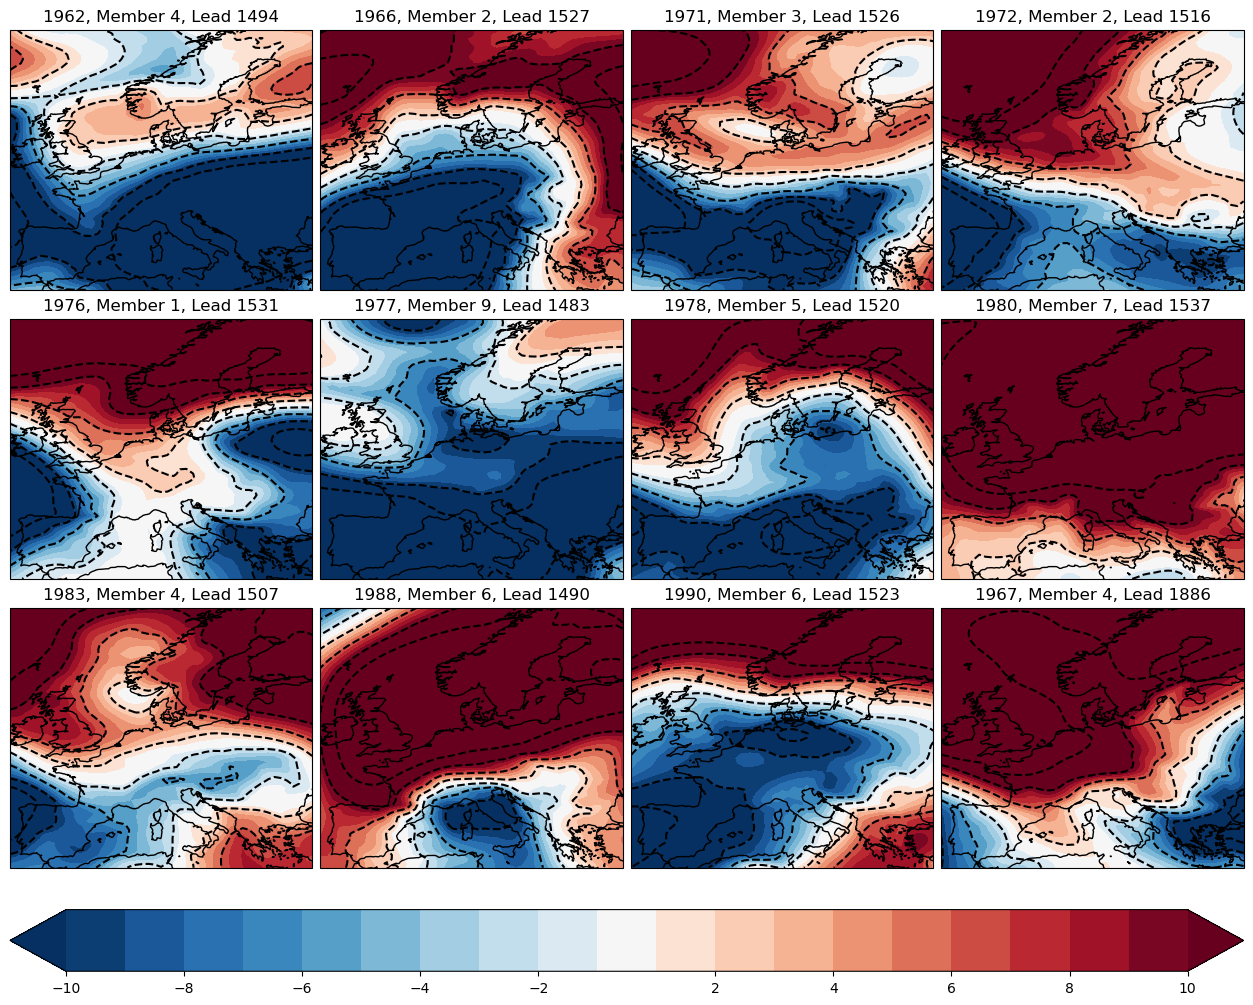

In [155]:
# Set up a plot with 3 rows and 4 columns
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15, 10), subplot_kw={"projection": ccrs.PlateCarree()}, layout="compressed")

# flatten the axs
axs_flat = axs.flatten()

# Loop over the first dozen
for i, arr_this in enumerate(third_dozen_arr):
    # Extract the tuple
    tuple_this = third_dozen_tuples[i]

    # Extract the init year, member and lead
    init_year = model_years[tuple_this[0]]
    member = members_list[tuple_this[1]]
    lead = tuple_this[2] + 1

    # Set up the title
    title = f"{init_year}, Member {member}, Lead {lead}"

    # Plot the data
    contour = axs_flat[i].contourf(
        lons,
        lats,
        (arr_this - model_psl_clim) / 100,
        cmap="RdBu_r",
        levels=psl_levels,
        extend="both"
    )

    # include contours
    axs_flat[i].contour(
        lons,
        lats,
        (arr_this - model_psl_clim) / 100,
        levels=psl_levels_contours,
        colors="black",
        linestyles="dashed"
    )

    # Add coastlines
    axs_flat[i].coastlines()

    # Add the title
    axs_flat[i].set_title(title)

# Add a colorbar
cbar = plt.colorbar(contour, ax=axs_flat, orientation="horizontal", pad=0.05)

# Set up the ticks for the cbar
cbar.set_ticks(psl_ticks)

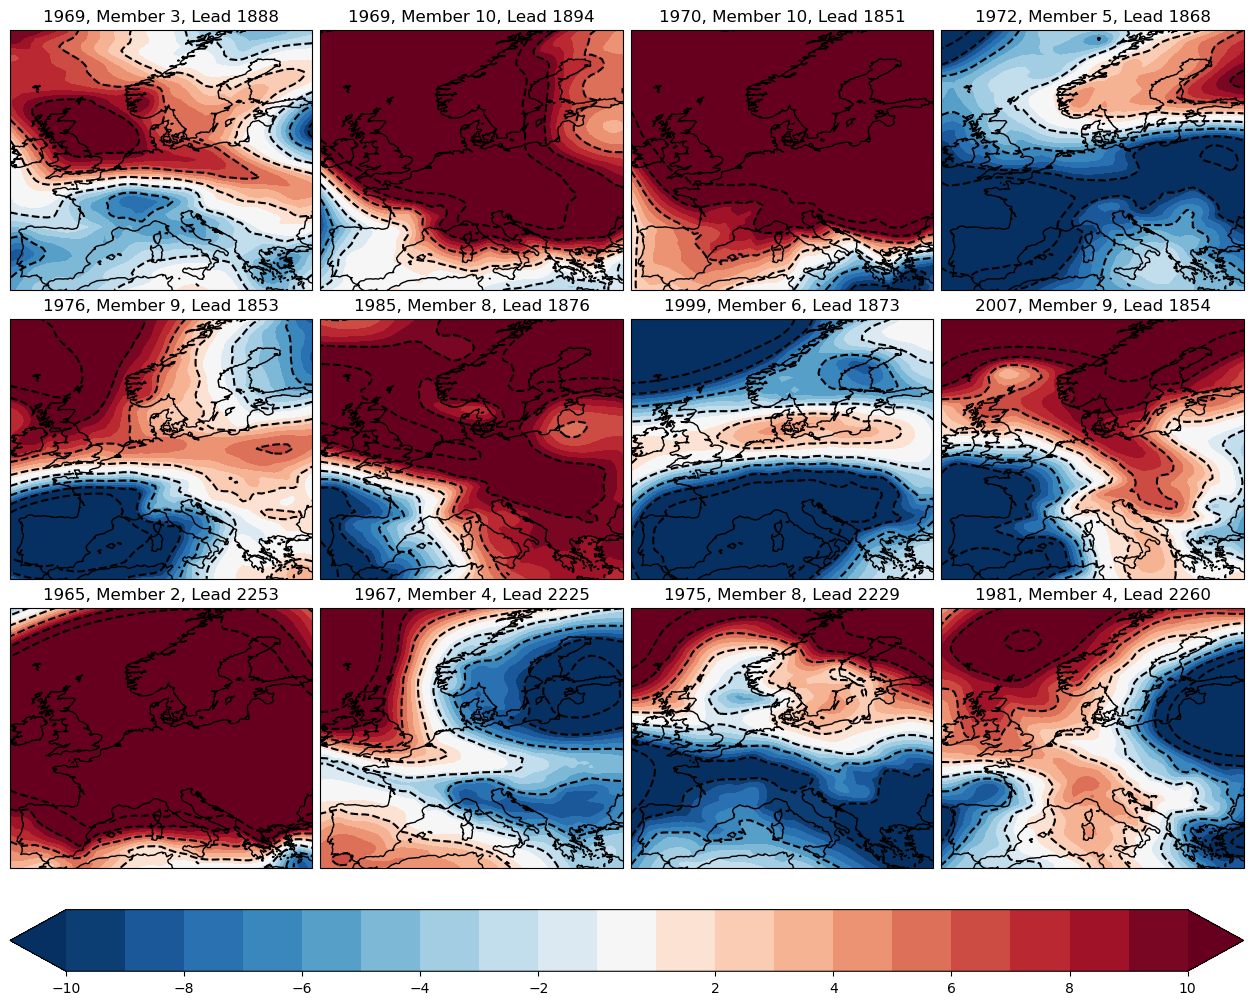

In [156]:
# Set up a plot with 3 rows and 4 columns
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15, 10), subplot_kw={"projection": ccrs.PlateCarree()}, layout="compressed")

# flatten the axs
axs_flat = axs.flatten()

# Loop over the first dozen
for i, arr_this in enumerate(fourth_dozen_arr):
    # Extract the tuple
    tuple_this = fourth_dozen_tuples[i]

    # Extract the init year, member and lead
    init_year = model_years[tuple_this[0]]
    member = members_list[tuple_this[1]]
    lead = tuple_this[2] + 1

    # Set up the title
    title = f"{init_year}, Member {member}, Lead {lead}"

    # Plot the data
    contour = axs_flat[i].contourf(
        lons,
        lats,
        (arr_this - model_psl_clim) / 100,
        cmap="RdBu_r",
        levels=psl_levels,
        extend="both"
    )

    # include contours
    axs_flat[i].contour(
        lons,
        lats,
        (arr_this - model_psl_clim) / 100,
        levels=psl_levels_contours,
        colors="black",
        linestyles="dashed"
    )

    # Add coastlines
    axs_flat[i].coastlines()

    # Add the title
    axs_flat[i].set_title(title)

# Add a colorbar
cbar = plt.colorbar(contour, ax=axs_flat, orientation="horizontal", pad=0.05)

# Set up the ticks for the cbar
cbar.set_ticks(psl_ticks)

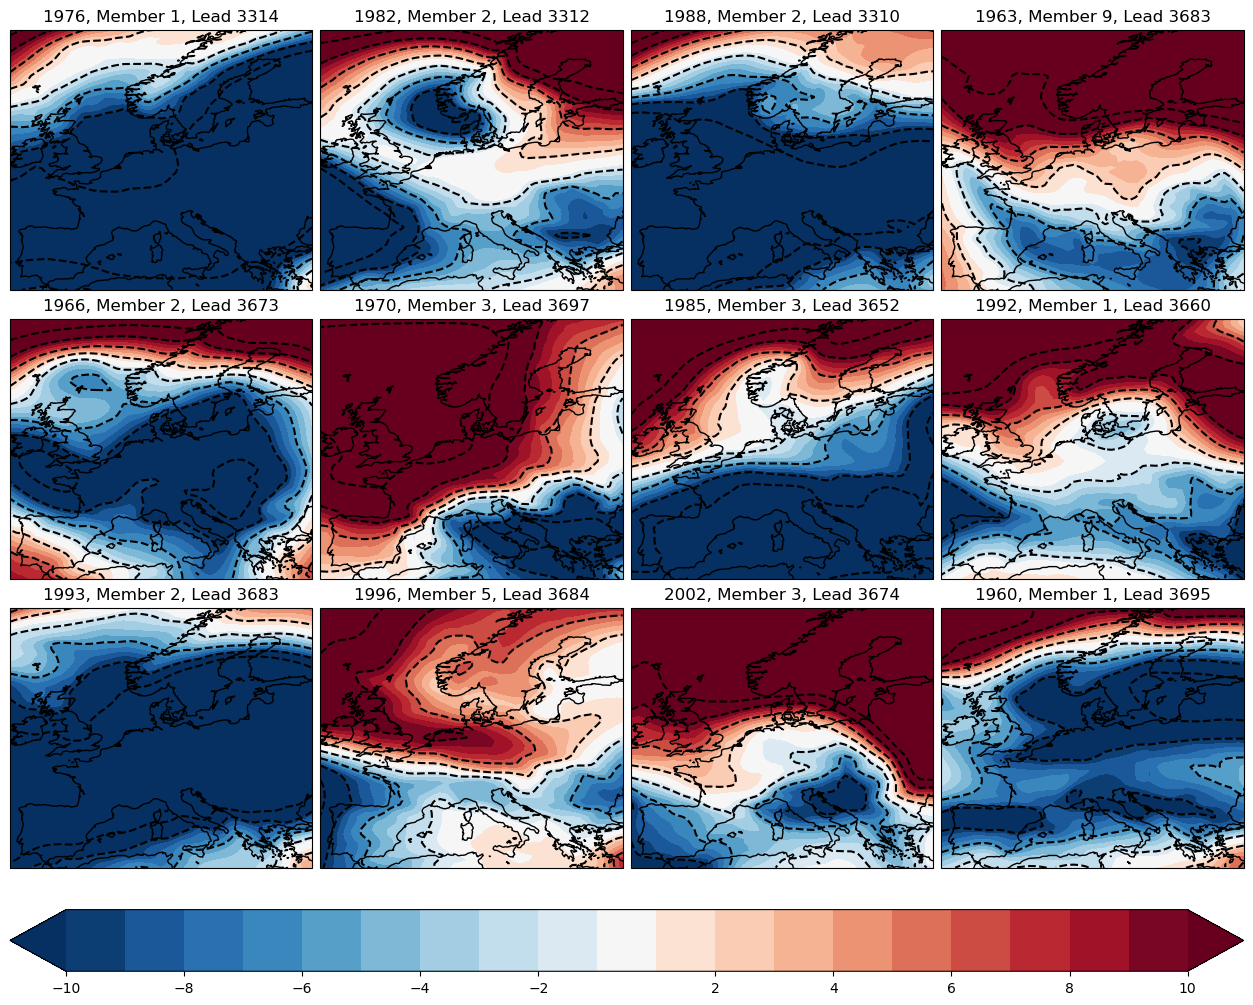

In [158]:
# Set up a plot with 3 rows and 4 columns
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15, 10), subplot_kw={"projection": ccrs.PlateCarree()}, layout="compressed")

# flatten the axs
axs_flat = axs.flatten()

# Loop over the first dozen
for i, arr_this in enumerate(sixth_dozen_arr):
    # Extract the tuple
    tuple_this = sixth_dozen_tuples[i]

    # Extract the init year, member and lead
    init_year = model_years[tuple_this[0]]
    member = members_list[tuple_this[1]]
    lead = tuple_this[2] + 1

    # Set up the title
    title = f"{init_year}, Member {member}, Lead {lead}"

    # Plot the data
    contour = axs_flat[i].contourf(
        lons,
        lats,
        (arr_this - model_psl_clim) / 100,
        cmap="RdBu_r",
        levels=psl_levels,
        extend="both"
    )

    # include contours
    axs_flat[i].contour(
        lons,
        lats,
        (arr_this - model_psl_clim) / 100,
        levels=psl_levels_contours,
        colors="black",
        linestyles="dashed"
    )

    # Add coastlines
    axs_flat[i].coastlines()

    # Add the title
    axs_flat[i].set_title(title)

# Add a colorbar
cbar = plt.colorbar(contour, ax=axs_flat, orientation="horizontal", pad=0.05)

# Set up the ticks for the cbar
cbar.set_ticks(psl_ticks)

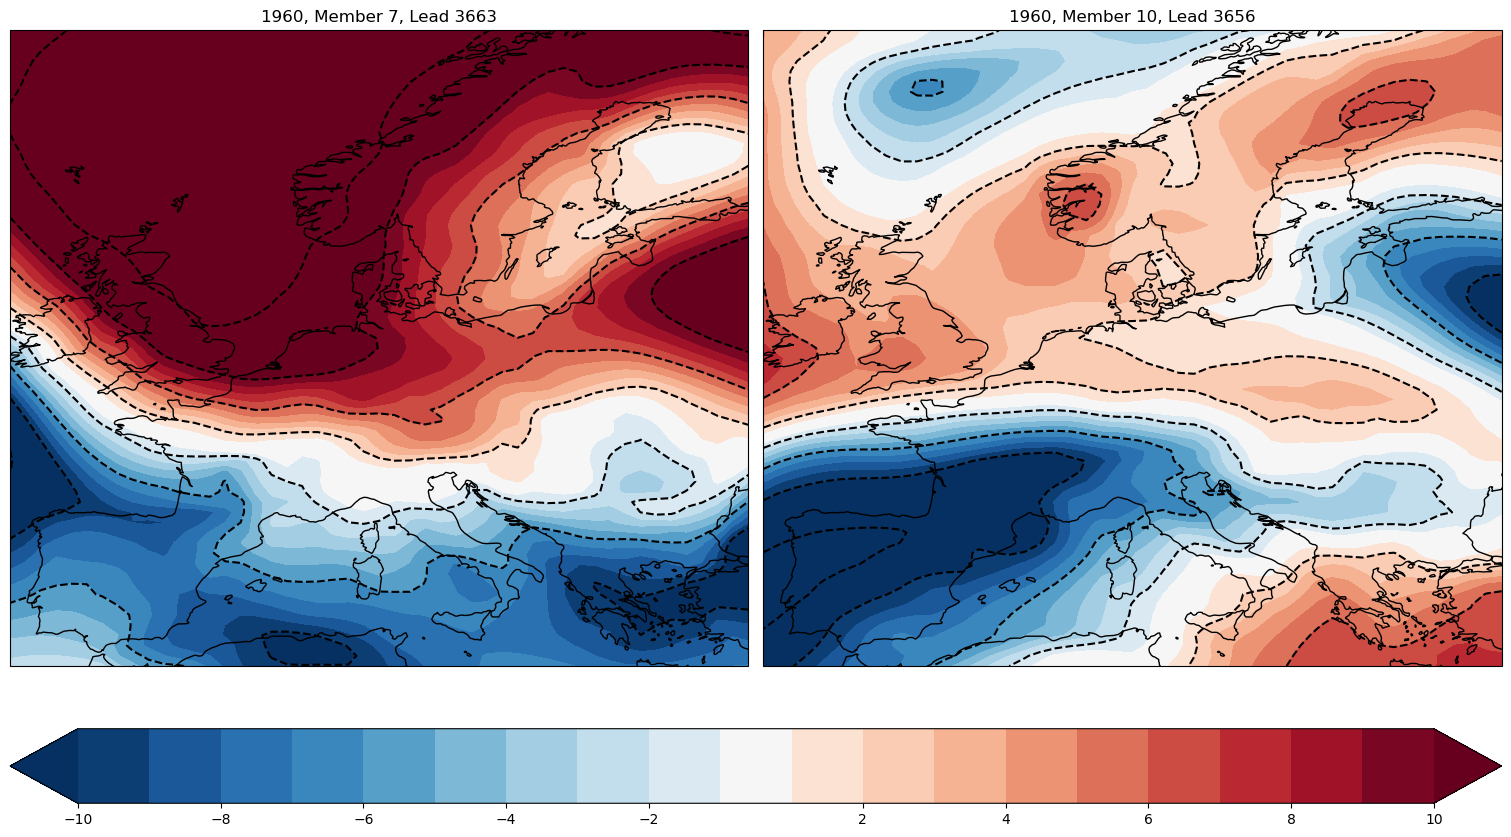

In [160]:
# Set up a plot with 3 rows and 4 columns
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 10), subplot_kw={"projection": ccrs.PlateCarree()}, layout="compressed")

# flatten the axs
axs_flat = axs.flatten()

# Loop over the first dozen
for i, arr_this in enumerate(seventh_dozen_arr):
    # Extract the tuple
    tuple_this = seventh_dozen_tuples[i]

    # Extract the init year, member and lead
    init_year = model_years[tuple_this[0]]
    member = members_list[tuple_this[1]]
    lead = tuple_this[2] + 1

    # Set up the title
    title = f"{init_year}, Member {member}, Lead {lead}"

    # Plot the data
    contour = axs_flat[i].contourf(
        lons,
        lats,
        (arr_this - model_psl_clim) / 100,
        cmap="RdBu_r",
        levels=psl_levels,
        extend="both"
    )

    # include contours
    axs_flat[i].contour(
        lons,
        lats,
        (arr_this - model_psl_clim) / 100,
        levels=psl_levels_contours,
        colors="black",
        linestyles="dashed"
    )

    # Add coastlines
    axs_flat[i].coastlines()

    # Add the title
    axs_flat[i].set_title(title)

# Add a colorbar
cbar = plt.colorbar(contour, ax=axs_flat, orientation="horizontal", pad=0.05)

# Set up the ticks for the cbar
cbar.set_ticks(psl_ticks)

/tmp/ipykernel_2067683/106594484.py:35: UserWarning: Adding colorbar to a different Figure <Figure size 1000x500 with 2 Axes> than <Figure size 1000x500 with 2 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(contour, ax=ax, orientation="horizontal", pad=0.05)


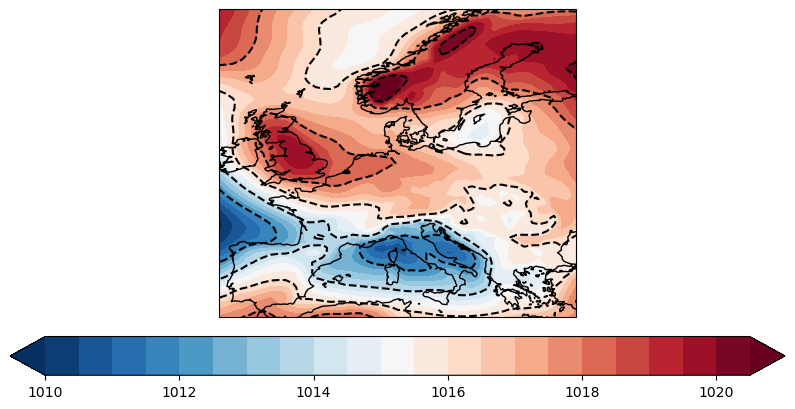

In [168]:
# plot the complete anomaly composite of all of the days
# Set up the figure
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={"projection": ccrs.PlateCarree()})

# set up the psl abs clevs for contour
psl_abs_clevs_contour = np.array(np.arange(1010, 1020 + 1, 2))

# Set up the ticks
psl_abs_ticks = np.array([1010, 1012, 1014, 1016, 1018, 1020])

# Plot the contours
contour_shading = ax.contourf(
    lons,
    lats,
    np.mean(red_dots_arr, axis=0) / 100, # Absolute
    cmap="RdBu_r",
    levels=psl_abs_clevs,
    extend="both"
)

# include contours
contours = ax.contour(
    lons,
    lats,
    np.mean(red_dots_arr, axis=0) / 100,
    levels=psl_abs_clevs_contour,
    colors="black",
    linestyles="dashed"
)

# Add coastlines
ax.coastlines()

# Add a colorbar
cbar = plt.colorbar(contour, ax=ax, orientation="horizontal", pad=0.05)

# Set up the ticks for the cbar
cbar.set_ticks(psl_abs_ticks)

In [170]:
psl_ticks

array([-10,  -8,  -6,  -4,  -2,   2,   4,   6,   8,  10])

In [171]:
psl_levels_contours

array([-14, -10,  -6,  -2,   2,   6,  10,  14])

/tmp/ipykernel_2067683/1068460917.py:30: UserWarning: Adding colorbar to a different Figure <Figure size 1000x500 with 2 Axes> than <Figure size 1000x500 with 2 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(contour, ax=ax, orientation="horizontal", pad=0.05, shrink=0.8)


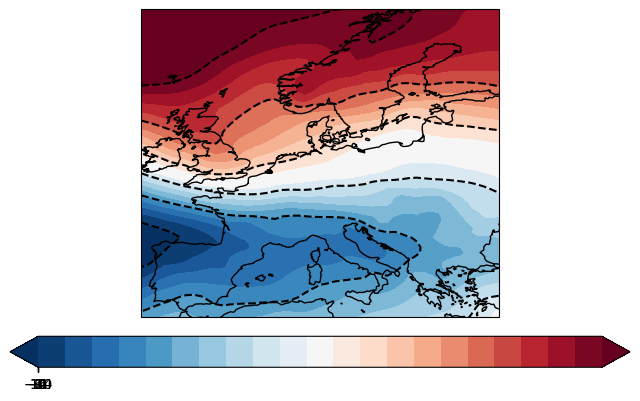

In [172]:
# now do the same but anomalies

# Set up the figure
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={"projection": ccrs.PlateCarree()})

# Plot the contours
contour_shading = ax.contourf(
    lons,
    lats,
    (np.mean(red_dots_arr, axis=0) - model_psl_clim) / 100, # Anomalies
    cmap="RdBu_r",
    levels=psl_levels,
    extend="both"
)

# include contours
contours = ax.contour(
    lons,
    lats,
    (np.mean(red_dots_arr, axis=0) - model_psl_clim) / 100,
    levels=psl_levels_contours,
    colors="black",
    linestyles="dashed"
)

# Add coastlines
ax.coastlines()

# Add a colorbar
cbar = plt.colorbar(contour, ax=ax, orientation="horizontal", pad=0.05, shrink=0.8)

# Set up the ticks for the cbar
cbar.set_ticks(psl_levels_contours)

In [98]:
%%time
# extract the values of the obs data djf n
obs_data_djf_n_vals = obs_data_djf_n.data

CPU times: user 2.05 s, sys: 1min 2s, total: 1min 4s
Wall time: 1min 10s


In [100]:
obs_data_djf_n_vals

masked_array(
  data=[[[ 98151.66 ,  98145.56 ,  98138.95 , ...,  99671.445,
           99736.586,  99799.78 ],
         [ 98235.43 ,  98229.01 ,  98223.27 , ...,  99780.79 ,
           99825.484,  99874.28 ],
         [ 98321.305,  98315.71 ,  98310.09 , ...,  99844.16 ,
           99885.21 ,  99926.73 ],
         ...,
         [100149.695, 100153.16 , 100156.92 , ..., 101287.35 ,
          101336.18 , 101384.51 ],
         [100156.62 , 100159.484, 100160.9  , ..., 101323.586,
          101370.914, 101418.13 ],
         [100160.53 , 100163.09 , 100162.65 , ..., 101357.8  ,
          101404.516, 101451.77 ]],

        [[ 99828.11 ,  99842.336,  99856.32 , ..., 100355.78 ,
          100343.59 , 100331.86 ],
         [ 99817.664,  99833.336,  99850.805, ..., 100431.38 ,
          100429.34 , 100424.3  ],
         [ 99814.875,  99834.33 ,  99852.92 , ..., 100510.22 ,
          100517.695, 100527.43 ],
         ...,
         [100036.27 , 100080.125, 100125.79 , ..., 101480.29 ,
          1

### Now do the same for DePreSys ###

First we need to assemble the init year, member, lead time dictionary.

In [2]:
# ------------------------------------------------
# First load the dataframe containing init year, member, lead time info
# ------------------------------------------------

# Set up the path
path_to_df = "/home/users/benhutch/unseen_multi_year/dfs/block_maxima_demand_net_wind_2025-03-19_10:02:16.csv"

# Assert that a file exists at the path
assert os.path.exists(path_to_df), "The file does not exist at the path provided."

# Load the dataframe
model_df = pd.read_csv(path_to_df)

In [3]:
model_df.head()

init_year  winter_year  member  demand_net_wind_dt_max  data_wind  \
0       1960            1       1               43.299338   3.477982   
1       1960            1       2               44.258005   3.137077   
2       1960            1       3               42.765023   3.108481   
3       1960            1       4               40.875478   4.073372   
4       1960            1       5               42.179870   3.777105   

   data_tas_c  sigmoid_total_wind_gen  UK_demand_dt  lead  
0    0.284075                2.090417     45.389755    89  
1   -0.239743                1.523360     45.781365    54  
2    1.816344                1.479193     44.244216    52  
3    1.943294                3.273830     44.149308    76  
4    1.029052                2.652933     44.832803    74

In [4]:
# ------------------------------------------------
# Select 100 random rows for testing purposes
# ------------------------------------------------

# Set the nrows
nrows_sel = 100
nrow_df = model_df.shape[0]

# Select the random rows
random_rows = np.random.choice(nrow_df, nrows_sel, replace=False)

# Select the random rows
model_df_subset = model_df.iloc[random_rows]

In [5]:
model_df_subset.tail()

init_year  winter_year  member  demand_net_wind_dt_max  data_wind  \
1294       1971            9       5               43.976066   3.533061   
3025       1987            6       6               42.796080   3.928326   
3422       1991            2       3               41.876002   4.648451   
3975       1996            2       6               42.516466   3.990398   
4538       2001            3       9               44.411361   3.385268   

      data_tas_c  sigmoid_total_wind_gen  UK_demand_dt  lead  
1294   -0.288837                2.189299     46.165365  2933  
3025    0.574164                2.961721     45.757802  1916  
3422   -0.480154                4.670017     46.546019   457  
3975    0.894347                3.093358     45.609824   435  
4538    0.064384                1.928623     46.339984   821

In [6]:
%%time
# ------------------------------------------------
# Set up a limited climatology in this case
# Using the monthly data
# ------------------------------------------------

sys.path.append("/home/users/benhutch/unseen_functions/")
from functions import load_model_data_xarray

# Set up the climateology years
climatology_years = np.arange(1990, 1995 + 1)

# Set up the climatology months
climatology_months = [12, 1, 2]

# First load the model data for tas
model_data_clim_tas = load_model_data_xarray(
    model_variable="tas",
    model="HadGEM3-GC31-MM",
    experiment="dcppA-hindcast",
    start_year=climatology_years[0],
    end_year=climatology_years[-1],
    first_fcst_year=climatology_years[0] + 1,
    last_fcst_year=climatology_years[-1] + 10,
    months=climatology_months,
    frequency="Amon",
    engine="netcdf4",
    parallel=False,
)

Model path: /gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/tas/HadGEM3-GC31-MM/merged_files


The model path root is gws
Number of unique variant labels: 10
For model: HadGEM3-GC31-MM
First 10 unique variant labels: ['r10i1p1f2' 'r1i1p1f2' 'r2i1p1f2' 'r3i1p1f2' 'r4i1p1f2' 'r5i1p1f2'
 'r6i1p1f2' 'r7i1p1f2' 'r8i1p1f2' 'r9i1p1f2']
Number of unique variant labels: 10
Unique variant labels: ['r10i1p1f2' 'r1i1p1f2' 'r2i1p1f2' 'r3i1p1f2' 'r4i1p1f2' 'r5i1p1f2'
 'r6i1p1f2' 'r7i1p1f2' 'r8i1p1f2' 'r9i1p1f2']
First 10 model files: ['tas_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r10i1p1f2_gn_196011-197103.nc', 'tas_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r1i1p1f2_gn_196011-197103.nc', 'tas_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r2i1p1f2_gn_196011-197103.nc', 'tas_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r3i1p1f2_gn_196011-197103.nc', 'tas_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r4i1p1f2_gn_196011-197103.nc', 'tas_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r5i1p1f2_gn_196011-197103.nc', 'tas_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r6i1p1f2_gn_196011-197103.nc', 'tas_Amon_HadGEM3-GC3

Processing init years: 100%|██████████| 6/6 [00:13<00:00,  2.24s/it]

CPU times: user 797 ms, sys: 303 ms, total: 1.1 s
Wall time: 14.2 s


In [7]:
# ------------------------------------------------
# Load the model data for sfcWind
# ------------------------------------------------

# Load the model data for wind
model_data_clim_wind = load_model_data_xarray(
    model_variable="sfcWind",
    model="HadGEM3-GC31-MM",
    experiment="dcppA-hindcast",
    start_year=climatology_years[0],
    end_year=climatology_years[-1],
    first_fcst_year=climatology_years[0] + 1,
    last_fcst_year=climatology_years[-1] + 10,
    months=climatology_months,
    frequency="Amon",
    engine="netcdf4",
    parallel=False,
)

Model path: /gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/sfcWind/HadGEM3-GC31-MM/merged_files
The model path root is gws
Number of unique variant labels: 10
For model: HadGEM3-GC31-MM
First 10 unique variant labels: ['r10i1p1f2' 'r1i1p1f2' 'r2i1p1f2' 'r3i1p1f2' 'r4i1p1f2' 'r5i1p1f2'
 'r6i1p1f2' 'r7i1p1f2' 'r8i1p1f2' 'r9i1p1f2']
Number of unique variant labels: 10
Unique variant labels: ['r10i1p1f2' 'r1i1p1f2' 'r2i1p1f2' 'r3i1p1f2' 'r4i1p1f2' 'r5i1p1f2'
 'r6i1p1f2' 'r7i1p1f2' 'r8i1p1f2' 'r9i1p1f2']
First 10 model files: ['sfcWind_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r10i1p1f2_gn_196011-197103.nc', 'sfcWind_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r1i1p1f2_gn_196011-197103.nc', 'sfcWind_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r2i1p1f2_gn_196011-197103.nc', 'sfcWind_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r3i1p1f2_gn_196011-197103.nc', 'sfcWind_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r4i1p1f2_gn_196011-197103.nc', 'sfcWind_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r

Processing init years:   0%|          | 0/6 [00:00<?, ?it/s]

Processing init years: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


In [9]:
import gev_functions as gev_funcs

In [10]:
import importlib
importlib.reload(gev_funcs)

<module 'gev_functions' from '/home/users/benhutch/unseen_multi_year/gev_functions.py'>

In [11]:
# ------------------------------------------------
# Test the function for extracting time points from model data
# ------------------------------------------------

# Run the function for tas
tas_merged_cube = gev_funcs.extract_sel_cubes(
    model_df=model_df_subset,
    model_var_name="tas",
)

0it [00:00, ?it/s]/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/fileformats/cf.py:880: IrisCfMissingVarWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'tas'
  warnings.warn(
47it [00:58,  1.25s/it]

Date 1989-02-27 12:00:00 already in the dates list


In [12]:
# ------------------------------------------------
# Do the same for sfcWind
# ------------------------------------------------

# Run the function for sfWind
sfcWind_merged_cube = gev_funcs.extract_sel_cubes(
    model_df=model_df_subset,
    model_var_name="sfcWind",
)

0it [00:00, ?it/s]/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/fileformats/cf.py:880: IrisCfMissingVarWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'sfcWind'
  warnings.warn(
47it [01:14,  1.58s/it]

Date 1989-02-27 12:00:00 already in the dates list


In [13]:
# ------------------------------------------------
# Translate the xarray datasets to iris cubes
# ------------------------------------------------

# Translate the xarray datasets to iris cubes
tas_clim_cube = model_data_clim_tas["tas"].to_iris()
sfcWind_clim_cube = model_data_clim_wind["sfcWind"].to_iris()

In [14]:
# ------------------------------------------------
# Restrict the data to the test europe box
# ------------------------------------------------

# Define the box to constrain to
test_europe_box = {
    "lon1": -11,  # degrees east
    "lon2": 30,
    "lat1": 35,  # degrees north
    "lat2": 70,
}

# Set up the constraint
constraint = iris.Constraint(
    longitude=lambda cell: test_europe_box["lon1"] <= cell <= test_europe_box["lon2"],
    latitude=lambda cell: test_europe_box["lat1"] <= cell <= test_europe_box["lat2"],
)

# limit between -180 and 180 using intersection
tas_merged_cube = tas_merged_cube.intersection(longitude=(-180, 180))
sfcWind_merged_cube = sfcWind_merged_cube.intersection(longitude=(-180, 180))

# limit between -180 and 180 using intersection
tas_clim_cube = tas_clim_cube.intersection(longitude=(-180, 180))
sfcWind_clim_cube = sfcWind_clim_cube.intersection(longitude=(-180, 180))


# Apply the constraint to the tas cube
tas_merged_cube_constrained = tas_merged_cube.extract(constraint)
sfcWind_merged_cube_constrained = sfcWind_merged_cube.extract(constraint)

# Do the same to the climatology
tas_climatology_constrained = tas_clim_cube.extract(constraint)
sfcWind_climatology_constrained = sfcWind_clim_cube.extract(constraint)

In [15]:
tas_merged_cube_constrained.coord("longitude").points

array([-11.25003052, -10.41668701,  -9.58334351,  -8.75003052,
        -7.91668701,  -7.08334351,  -6.25003052,  -5.41668701,
        -4.58334351,  -3.75003052,  -2.91668701,  -2.08334351,
        -1.25003052,  -0.41668701,   0.41666666,   1.25      ,
         2.08333325,   2.91666675,   3.75      ,   4.58333302,
         5.41666651,   6.24999952,   7.08333302,   7.91666651,
         8.75      ,   9.58333302,  10.41666698,  11.25      ,
        12.08333302,  12.91666698,  13.75      ,  14.58333302,
        15.41666698,  16.25      ,  17.08333206,  17.91666603,
        18.74999809,  19.58333206,  20.41666603,  21.24999809,
        22.08333206,  22.91666603,  23.74999809,  24.58333206,
        25.41666603,  26.24999809,  27.08333206,  27.91666603,
        28.74999809,  29.58333206,  30.41666603])

In [16]:
tas_climatology_constrained

<iris 'Cube' of air_temperature / (K) (init: 6; -- : 10; lead: 125; latitude: 63; longitude: 49)>

In [17]:
# ------------------------------------------------
# Subset the climatology to the correct months
# ------------------------------------------------

# Set up the winter years
winter_years = np.arange(1, 11 + 1)

# Set up an empty list with the leads to extract
leads_to_extract = []

# loop over the winter ye3ars
for i, winter_year in enumerate(winter_years):
    leads_this = np.arange((i * 12) + 2, (i * 12) + 2 + 3 + 1)

    leads_to_extract.extend(leads_this)


# format this as a list of ints
leads_to_extract = [int(lead) for lead in leads_to_extract]

# Extract the leads from the tas climatology
tas_climatology_constrained_extracted = tas_climatology_constrained.extract(
    iris.Constraint(lead=leads_to_extract)
)
sfcWind_climatology_constrained_extracted = sfcWind_climatology_constrained.extract(
    iris.Constraint(lead=leads_to_extract)
)

# Take te mean over the "lead", "member", and "init" dimesnions
tas_climatology_constrained_extracted_mean = tas_climatology_constrained_extracted.collapsed(
    ["lead", "member", "init"], iris.analysis.MEAN
)
sfcWind_climatology_constrained_extracted_mean = sfcWind_climatology_constrained_extracted.collapsed(
    ["lead", "member", "init"], iris.analysis.MEAN
)


/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'init', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'init'. Ignoring bounds.
  warnings.warn(
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'lead', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'lead'. Ignoring bounds.
  warnings.warn(
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'member', with 0 bound(s). Contiguous bounds are only defined for 1D coordina

In [18]:
sfcWind_climatology_constrained_extracted_mean

<iris 'Cube' of wind_speed / (m s-1) (latitude: 63; longitude: 49)>

In [19]:
tas_merged_cube_constrained

<iris 'Cube' of air_temperature / (K) (-- : 100; latitude: 64; longitude: 51)>

In [20]:
tas_merged_cube_constrained.coord("longitude").points

array([-11.25003052, -10.41668701,  -9.58334351,  -8.75003052,
        -7.91668701,  -7.08334351,  -6.25003052,  -5.41668701,
        -4.58334351,  -3.75003052,  -2.91668701,  -2.08334351,
        -1.25003052,  -0.41668701,   0.41666666,   1.25      ,
         2.08333325,   2.91666675,   3.75      ,   4.58333302,
         5.41666651,   6.24999952,   7.08333302,   7.91666651,
         8.75      ,   9.58333302,  10.41666698,  11.25      ,
        12.08333302,  12.91666698,  13.75      ,  14.58333302,
        15.41666698,  16.25      ,  17.08333206,  17.91666603,
        18.74999809,  19.58333206,  20.41666603,  21.24999809,
        22.08333206,  22.91666603,  23.74999809,  24.58333206,
        25.41666603,  26.24999809,  27.08333206,  27.91666603,
        28.74999809,  29.58333206,  30.41666603])

In [21]:
tas_merged_cube_constrained.coord("latitude").points

array([34.722229  , 35.27778625, 35.83334351, 36.38889313, 36.94445038,
       37.50000763, 38.05556488, 38.61112213, 39.16667938, 39.72223663,
       40.27777863, 40.83333588, 41.38889313, 41.94445038, 42.50000763,
       43.05556488, 43.61112213, 44.16667938, 44.72223663, 45.27777863,
       45.83333588, 46.38889313, 46.94445038, 47.50000763, 48.05556488,
       48.61112213, 49.16667938, 49.72223663, 50.27777863, 50.83333588,
       51.38889313, 51.94445038, 52.50000763, 53.05556488, 53.61112213,
       54.16667938, 54.72223663, 55.27777863, 55.83333588, 56.38889313,
       56.94445038, 57.50000763, 58.05556488, 58.61112213, 59.16667938,
       59.72223663, 60.27777863, 60.83333588, 61.38889313, 61.94445038,
       62.50000763, 63.05556488, 63.61112213, 64.16667938, 64.72223663,
       65.27777863, 65.83333588, 66.38889313, 66.94445038, 67.50000763,
       68.05556488, 68.61112213, 69.16667938, 69.72223663])

In [22]:
# ------------------------------------------------
# Calcualet the mean for the merged cubes and regrid
# ------------------------------------------------

tas_cube_mean = tas_merged_cube_constrained.collapsed(
    ["realization", "time"], iris.analysis.MEAN
)

sfcWind_cube_mean = sfcWind_merged_cube_constrained.collapsed(
    ["realization", "time"], iris.analysis.MEAN
)

# regrid to the clim cube
tas_cube_mean_rg = tas_cube_mean.regrid(tas_climatology_constrained_extracted_mean, iris.analysis.Linear())
sfcWind_cube_mean_rg = sfcWind_cube_mean.regrid(sfcWind_climatology_constrained_extracted_mean, iris.analysis.Linear())

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'realization', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'realization'. Ignoring bounds.
  warnings.warn(
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2182: IrisVagueMetadataWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'realization', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'realization'. Ignoring bounds.
  warnings.warn(
/home/

In [23]:
# ------------------------------------------------
# Calculate the anomalies
# ------------------------------------------------

# Calculate the anomalies for temperature
tas_anomalies = tas_cube_mean_rg - tas_climatology_constrained_extracted_mean

# Calculate the anomalies for wind
sfcWind_anomalies = sfcWind_cube_mean_rg - sfcWind_climatology_constrained_extracted_mean

In [24]:
%%time
# ------------------------------------------------
# Now process all of the computations to extract the array values
# NOTE: may take a while
# ------------------------------------------------

# Extract the values for temperature
tas_anoms_arr = tas_anomalies.data

# Extract the values for wind
sfcWind_anoms_arr = sfcWind_anomalies.data

CPU times: user 1min 12s, sys: 2min 44s, total: 3min 57s
Wall time: 5min 53s


In [25]:
np.shape(tas_anoms_arr)

(63, 49)

In [26]:
np.shape(sfcWind_anoms_arr)

(63, 49)

In [27]:
# ---------------------------------
# Set up a mask for the europe land mass
# ---------------------------------

import cartopy.io.shapereader as shpreader

# Set up the LONS and LATS
LONS, LATS = iris.analysis.cartography.get_xy_grids(tas_cube_mean_rg)

# Flatten the lats and lons
x, y = LONS.flatten(), LATS.flatten()

# Set up the countries shapefile
countries_shp = shpreader.natural_earth(
    resolution="10m", category="cultural", name="admin_0_countries"
)

# ---------------------------------
# Set up the land shapefile
# ---------------------------------

# Set up the land shapefile
MASK_MATRIX_TMP = np.zeros([len(x), 1])
country_shapely = []
for country_record in shpreader.Reader(countries_shp).records():
        country_shapely.append(country_record.geometry)

# ---------------------------------
# Create a mask for the land
# ---------------------------------
import shapely.geometry

# Loop over the x points
# Create a mask for the country
for i in range(0, len(x)):
    point = shapely.geometry.Point(x[i], y[i])
    for country in country_shapely:
        if country.contains(point) == True:
            MASK_MATRIX_TMP[i, 0] = 1.0

MASK_MATRIX_RESHAPE = np.reshape(MASK_MATRIX_TMP, (np.shape(LONS)))

In [28]:
# ---------------------------------
# Apply the mask to the temperature and wind data
# ---------------------------------

# Apply the mask to the temperature data
tas_anoms_arr_masked = np.ma.masked_where(MASK_MATRIX_RESHAPE == 0, tas_anoms_arr)

# Apply the mask to the wind data
sfcWind_anoms_arr_masked = np.ma.masked_where(MASK_MATRIX_RESHAPE == 0, sfcWind_anoms_arr)

In [29]:
print(np.min(tas_anoms_arr_masked), np.max(tas_anoms_arr_masked))
print(np.min(sfcWind_anoms_arr), np.max(sfcWind_anoms_arr))

-8.095795 0.45388794
-5.162456 1.4486876


In [30]:
# ---------------------------------
# Set up the clevs for temperature and wind speed
# ---------------------------------

# Set up the clevs for temperature
temp_clevs = np.array([-5, -4, -3, -2, -1, 1, 2, 3, 4, 5])

# Set up the clevs for wind speed
wind_clevs = np.array([-5, -4, -3, -2, -1, 1, 2, 3, 4, 5])

In [31]:
# ---------------------------------
# Set up the number of dates
# ---------------------------------

# Set up the number of dates
num_days = len(model_df_subset)

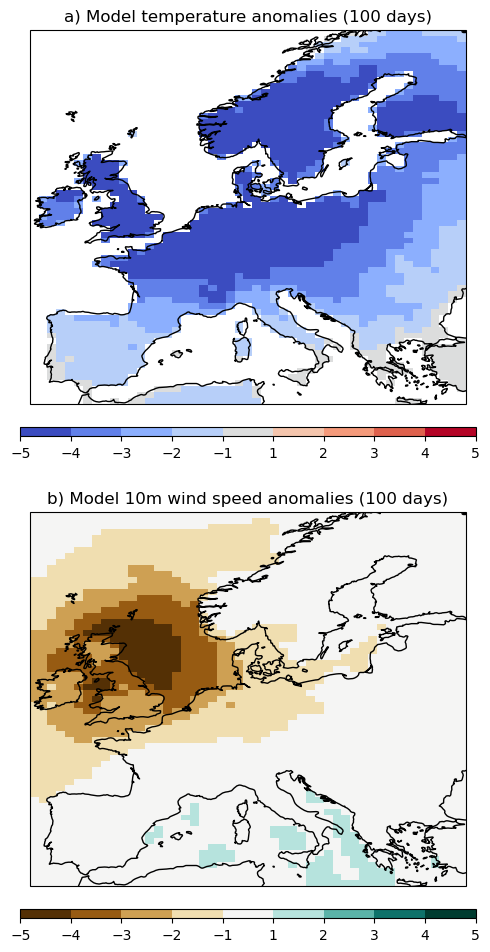

In [34]:
# ---------------------------------
# Plot the figure
# ---------------------------------

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import BoundaryNorm

# Set up the clevs for temperature
temp_clevs = np.array([-5, -4, -3, -2, -1, 1, 2, 3, 4, 5])

# Set up the clevs for wind speed
wind_clevs = np.array([-5, -4, -3, -2, -1, 1, 2, 3, 4, 5])

# Create a norm for temperature
temp_norm = BoundaryNorm(temp_clevs, ncolors=plt.cm.coolwarm.N, clip=True)

# Create a norm for wind speed
wind_norm = BoundaryNorm(wind_clevs, ncolors=plt.cm.BrBG.N, clip=True)

# Set up a figure with 2 rows and 1 column
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5, 10), subplot_kw={"projection": ccrs.PlateCarree()})

# Plot the temperature anomalies
ax1 = axs[0]

# Set up the map using pcolormesh with temperature levels
mymap1 = ax1.pcolormesh(
    tas_cube_mean_rg.coord("longitude").points,
    tas_cube_mean_rg.coord("latitude").points,
    tas_anoms_arr_masked,
    cmap="coolwarm",
    norm=temp_norm,
    transform=ccrs.PlateCarree(),
    shading='auto'
)

ax1.coastlines()

# Set up the title
ax1.set_title(f"a) Model temperature anomalies ({num_days} days)")

# Include a colorbar to the side
cbar1 = plt.colorbar(mymap1, ax=ax1, orientation="horizontal", pad=0.05, aspect=50)
cbar1.set_ticks(temp_clevs)

# Plot the wind anomalies
ax2 = axs[1]

# Set up the map using pcolormesh with wind speed levels
mymap2 = ax2.pcolormesh(
    sfcWind_cube_mean_rg.coord("longitude").points,
    sfcWind_cube_mean_rg.coord("latitude").points,
    sfcWind_anoms_arr,
    cmap="BrBG",
    norm=wind_norm,
    transform=ccrs.PlateCarree(),
    shading='auto'
)

ax2.coastlines()

# Include a colorbar to the side
cbar2 = plt.colorbar(mymap2, ax=ax2, orientation="horizontal", pad=0.05, aspect=50)
cbar2.set_ticks(wind_clevs)

# Set up the title
ax2.set_title(f"b) Model 10m wind speed anomalies ({num_days} days)")

# Set up a tight layout
plt.tight_layout()

#### Look at co-occurence of low wind and cold temperature conditions ####

In [ ]:
# Set up the countries for which to extract the data
basecountry

In [2]:
# ---------------------------------
# Load the dataframe containing the dates for the ERA5 period
# ---------------------------------

# Set up the path to the obs dnw dataframe
obs_dnw_path = "/home/users/benhutch/unseen_multi_year/dfs/UK_obs_demand_net_wind_max_djf_1960-2017_2025-03-18.csv"

# Load the obs dnw dataframe
obs_dnw_df = pd.read_csv(obs_dnw_path)

In [3]:
%%time
# ---------------------------------
# Load in the ERA5 daily temperature data
# ---------------------------------

# set up the data path to the temp data
temp_path = "/gws/nopw/j04/canari/users/benhutch/ERA5/ERA5_t2m_daily_1950_2020.nc"

# Load the data
temp_cube = iris.load_cube(temp_path, "t2m")

CPU times: user 36.7 ms, sys: 14.9 ms, total: 51.6 ms
Wall time: 885 ms


In [4]:
%%time
# ---------------------------------
# Load in the ERA5 daily 10m wind speed data
# ---------------------------------

# Set up the base path
base_path = "/gws/nopw/j04/canari/users/benhutch/ERA5/"

# Set up the path to the wind data
obs_path = os.path.join(base_path, "ERA5_wind_daily_1952_2020.nc")

# Load the data
wind_cube = iris.load_cube(obs_path, "si10")

CPU times: user 4.82 ms, sys: 4.97 ms, total: 9.79 ms
Wall time: 11.6 ms


In [5]:
%%time
# ---------------------------------
# Load in the ERA5 data for mean sea level pressure
# ---------------------------------

# # Set up the path to the data
data_path = (
    "/gws/nopw/j04/canari/users/benhutch/ERA5/ERA5_msl_daily_1960_2020_daymean.nc"
)

# # Load the data
psl_cube = iris.load_cube(data_path, "msl")

CPU times: user 73.4 ms, sys: 94.3 ms, total: 168 ms
Wall time: 171 ms


In [6]:
# ---------------------------------
# Restrict both obs datasets to a specific Europe box
# ---------------------------------

# Define the box to constrain to
test_europe_box = {
    "lon1": -11,  # degrees east
    "lon2": 30,
    "lat1": 35,  # degrees north
    "lat2": 70,
}

# Define the constraints
constraints = iris.Constraint(
    longitude=lambda cell: test_europe_box["lon1"] <= cell <= test_europe_box["lon2"],
    latitude=lambda cell: test_europe_box["lat1"] <= cell <= test_europe_box["lat2"],
)

# Apply the constraints
temp_cube_eu = temp_cube.extract(constraints)
wind_cube_eu = wind_cube.extract(constraints)
psl_cube_eu = psl_cube.extract(constraints)

In [7]:
temp_cube_eu

<iris 'Cube' of 2 metre temperature / (K) (time: 25933; latitude: 124; longitude: 146)>

In [8]:
# ---------------------------------
# Restrict the obs data to specific dates
# ---------------------------------

# Define the start and end dates
start_date = "1960-12-01"
end_date = "2017-03-01"

# Convert the dates to datetime objects
start_date_dt = pd.to_datetime(start_date)
end_date_dt = pd.to_datetime(end_date)

# Create a time constraint
time_constraint = iris.Constraint(time=lambda cell: start_date_dt <= cell.point < end_date_dt)

# Apply the date constraints
temp_cube_eu = temp_cube_eu.extract(time_constraint)

# Same for the wind data
wind_cube_eu = wind_cube_eu.extract(time_constraint)

# Same for the pressure data
psl_cube_eu = psl_cube_eu.extract(time_constraint)

# Subset the cubes to months 12, 1, 2
temp_cube_eu = temp_cube_eu.extract(iris.Constraint(time=lambda cell: cell.point.month in [12, 1, 2]))

# Same for the wind data
wind_cube_eu = wind_cube_eu.extract(iris.Constraint(time=lambda cell: cell.point.month in [12, 1, 2]))

# Same for the pressure data
psl_cube_eu = psl_cube_eu.extract(iris.Constraint(time=lambda cell: cell.point.month in [12, 1, 2]))

In [9]:
# ---------------------------------
# Calculate the climatology for the observed datasets
# ---------------------------------

# Calculate the climatology for temp data
temp_climatology = temp_cube_eu.collapsed("time", iris.analysis.MEAN)

# Calculate the climatology for wind data
wind_climatology = wind_cube_eu.collapsed("time", iris.analysis.MEAN)

# Calculate the climatology for pressure data
psl_climatology = psl_cube_eu.collapsed("time", iris.analysis.MEAN)

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'time', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'time'. Ignoring bounds.
  warnings.warn(
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'time', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'time'. Ignoring bounds.
  warnings.warn(
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2182: IrisVagueMetadataWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(


In [10]:
# Extract the dates from the obs dnw dataframe
dates = pd.to_datetime(obs_dnw_df["time"]).values

In [11]:
dates

array(['1960-12-13T00:00:00.000000000', '1961-12-18T00:00:00.000000000',
       '1963-02-22T00:00:00.000000000', '1964-02-20T00:00:00.000000000',
       '1964-12-18T00:00:00.000000000', '1966-01-17T00:00:00.000000000',
       '1966-12-14T00:00:00.000000000', '1968-02-20T00:00:00.000000000',
       '1969-02-17T00:00:00.000000000', '1970-02-11T00:00:00.000000000',
       '1971-01-03T00:00:00.000000000', '1972-01-05T00:00:00.000000000',
       '1973-02-26T00:00:00.000000000', '1973-12-24T00:00:00.000000000',
       '1975-02-10T00:00:00.000000000', '1976-02-18T00:00:00.000000000',
       '1977-01-12T00:00:00.000000000', '1978-02-15T00:00:00.000000000',
       '1979-01-27T00:00:00.000000000', '1980-02-26T00:00:00.000000000',
       '1981-02-15T00:00:00.000000000', '1981-12-25T00:00:00.000000000',
       '1983-02-13T00:00:00.000000000', '1984-02-14T00:00:00.000000000',
       '1985-01-19T00:00:00.000000000', '1986-02-20T00:00:00.000000000',
       '1987-01-31T00:00:00.000000000', '1987-12-08

In [12]:
# ---------------------------------
# Make sure the dates are in the correct datetime format
# ---------------------------------

# Convert the dates to datetime objects
dates = pd.to_datetime(dates)

In [14]:
# ---------------------------------
# Format the dates as cftime objects
# ---------------------------------

# Convert the dates to cftime objects
dates_cf = [cftime.datetime(d.year, d.month, d.day) for d in dates]

# Extract the time points from the temp cube
time_points_temp = temp_cube_eu.coord("time").points

# Extract the time points from the wind cube
time_points_wind = wind_cube_eu.coord("time").points

# Extract the time points from the psl cube
time_points_psl = psl_cube_eu.coord("time").points

# Extract the time units from the temp cube
time_units_temp = temp_cube_eu.coord("time").units
calendar_temp = temp_cube_eu.coord("time").units.calendar

# Same for the wind data
time_units_wind = wind_cube_eu.coord("time").units
calendar_wind = wind_cube_eu.coord("time").units.calendar

# same for the psl data
time_points_psl = psl_cube_eu.coord("time").points
time_units_psl = psl_cube_eu.coord("time").units.calendar

# Convert the dates to cftime objects
dates_temp_cf = cftime.num2date(
    time_points_temp, units=time_units_temp.origin, calendar=calendar_temp
)

# Same for wind
dates_wind_cf = cftime.num2date(
    time_points_wind, units=time_units_wind.origin, calendar=calendar_wind
)

# same for psl
dates_psl_cf = cftime.num2date(
    time_points_psl, units="hours since 1900-01-01", calendar=calendar_wind
)

# Convert to cftime datetime objects
dates_temp_cf = [cftime.datetime(d.year, d.month, d.day) for d in dates_temp_cf]

# Same for wind
dates_wind_cf = [cftime.datetime(d.year, d.month, d.day) for d in dates_wind_cf]

# same for psl
dates_psl_cf = [cftime.datetime(d.year, d.month, d.day) for d in dates_psl_cf]

In [15]:
# ---------------------------------
# Extract the correct dates to create the composites
# ---------------------------------

# Set up an empty cubelist for temperature
temp_composite_list = iris.cube.CubeList()

# Set up an empty cubelist for wind
wind_composite_list = iris.cube.CubeList()

# Set up an empty cubelist for pressure
psl_composite_list = iris.cube.CubeList()

# Loop over the dates
for date in tqdm(dates_cf[:-1]):
    # Find the index where this date exists
    index_temp = np.where(np.array(dates_temp_cf) == date)[0][0]
    index_wind = np.where(np.array(dates_wind_cf) == date)[0][0]
    index_psl = np.where(np.array(dates_psl_cf) == date)[0][0]

    # Extract the cube at this index
    temp_cube_date = temp_cube_eu[index_temp]
    wind_cube_date = wind_cube_eu[index_wind]
    psl_cube_date = psl_cube_eu[index_psl]

    # Append to the cubelist
    temp_composite_list.append(temp_cube_date)
    wind_composite_list.append(wind_cube_date)
    psl_composite_list.append(psl_cube_date)

# Merge the cubes
temp_composite = temp_composite_list.merge_cube()
wind_composite = wind_composite_list.merge_cube()
psl_composite = psl_composite_list.merge_cube()

100%|██████████| 57/57 [00:00<00:00, 75.82it/s]


In [16]:
# ---------------------------------
# Calculate the anomalies
# ---------------------------------

# Calculate the anomalies for temperature
temp_anomalies = temp_composite.collapsed("time", iris.analysis.MEAN) - temp_climatology

# Calculate the anomalies for wind
wind_anomalies = wind_composite.collapsed("time", iris.analysis.MEAN) - wind_climatology

# Calculate the anomalies for pressure
psl_anomalies = psl_composite.collapsed("time", iris.analysis.MEAN) - psl_climatology

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'time', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'time'. Ignoring bounds.
  warnings.warn(
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'time', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'time'. Ignoring bounds.
  warnings.warn(
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2182: IrisVagueMetadataWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(


In [17]:
%%time
# ---------------------------------
# Extract the values
# ---------------------------------

# Extract the values for temperature
temp_anoms_arr = temp_anomalies.data

# Extract the values for wind
wind_anoms_arr = wind_anomalies.data

CPU times: user 2.01 s, sys: 34 s, total: 36.1 s
Wall time: 7min 2s


In [18]:
%%time
# ---------------------------------
# Extract the PSL data
# ---------------------------------

# Extract the values for pressure
psl_anoms_arr = psl_anomalies.data

CPU times: user 1.47 s, sys: 10.3 s, total: 11.8 s
Wall time: 9.97 s


In [19]:
np.min(psl_anoms_arr)

np.float32(-555.7969)

In [21]:
np.max(psl_anoms_arr)

np.float32(1286.1328)

In [22]:
# ---------------------------------
# Set up a mask for the europe land mass
# ---------------------------------

import cartopy.io.shapereader as shpreader

# Set up the LONS and LATS
LONS, LATS = iris.analysis.cartography.get_xy_grids(temp_anomalies)

# Flatten the lats and lons
x, y = LONS.flatten(), LATS.flatten()

# Set up the countries shapefile
countries_shp = shpreader.natural_earth(
    resolution="10m", category="cultural", name="admin_0_countries"
)

In [23]:
%%time
# ---------------------------------
# Set up the land shapefile
# ---------------------------------

# Set up the land shapefile
MASK_MATRIX_TMP = np.zeros([len(x), 1])
country_shapely = []
for country_record in shpreader.Reader(countries_shp).records():
        country_shapely.append(country_record.geometry)

CPU times: user 812 ms, sys: 6.58 ms, total: 818 ms
Wall time: 839 ms


In [24]:
country_shapely

[<MULTIPOLYGON (((117.704 4.163, 117.704 4.163, 117.738 4.157, 117.784 4.157,...>,
 <MULTIPOLYGON (((117.704 4.163, 117.697 4.169, 117.644 4.215, 117.64 4.227, ...>,
 <MULTIPOLYGON (((-69.51 -17.507, -69.506 -17.585, -69.497 -17.621, -69.476 -...>,
 <POLYGON ((-69.51 -17.507, -69.51 -17.505, -69.508 -17.434, -69.511 -17.399,...>,
 <MULTIPOLYGON (((-69.51 -17.507, -69.638 -17.626, -69.684 -17.656, -69.729 -...>,
 <MULTIPOLYGON (((-67.194 -22.822, -67.143 -22.743, -67.113 -22.71, -67.038 -...>,
 <POLYGON ((33.781 34.976, 33.76 34.98, 33.717 34.978, 33.702 34.973, 33.703 ...>,
 <MULTIPOLYGON (((33.782 34.976, 33.781 34.976, 33.78 34.979, 33.776 34.98, 3...>,
 <MULTIPOLYGON (((77.8 35.495, 77.815 35.473, 77.834 35.452, 77.857 35.437, 7...>,
 <MULTIPOLYGON (((78.918 33.386, 78.916 33.388, 78.824 33.461, 78.801 33.494,...>,
 <POLYGON ((34.248 31.211, 34.264 31.224, 34.316 31.257, 34.351 31.289, 34.35...>,
 <MULTIPOLYGON (((34.481 31.583, 34.52 31.558, 34.556 31.54, 34.528 31.52, 34...>,
 <PO

In [25]:
# ---------------------------------
# Create a mask for the land
# ---------------------------------
import shapely.geometry

# Loop over the x points
# Create a mask for the country
for i in range(0, len(x)):
    point = shapely.geometry.Point(x[i], y[i])
    for country in country_shapely:
        if country.contains(point) == True:
            MASK_MATRIX_TMP[i, 0] = 1.0

MASK_MATRIX_RESHAPE = np.reshape(MASK_MATRIX_TMP, (np.shape(LONS)))

In [26]:
# print the number of 1s in the mask
np.sum(MASK_MATRIX_RESHAPE)

np.float64(9512.0)

In [27]:
# ---------------------------------
# Apply the mask to the temperature and wind data
# ---------------------------------

# Apply the mask to the temperature data
temp_anoms_arr_masked = np.ma.masked_where(MASK_MATRIX_RESHAPE == 0, temp_anoms_arr)

In [41]:
np.min(wind_anoms_arr)

np.float32(-5.5433774)

In [43]:
np.max(wind_anoms_arr)

np.float32(1.5392466)

In [39]:
# ---------------------------------
# Set up the clevs for temperature and wind speed
# ---------------------------------

# Set up the clevs for temperature
temp_clevs = np.array([-5, -4, -3, -2, -1, 1, 2, 3, 4, 5])

# Set up the clevs for wind speed
wind_clevs = np.array([-5, -4, -3, -2, -1, 1, 2, 3, 4, 5])

# Set up the clevs for pressure
psl_levels = np.array([-12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

In [29]:
# ---------------------------------
# Set up the number of days
# ---------------------------------

# Set up the number of days for obs
num_days = len(dates)

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1646: UserWarning: The following kwargs were not used by contour: 'tranform'
  result = super().contourf(*args, **kwargs)
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1646: UserWarning: The following kwargs were not used by contour: 'tranform'
  result = super().contourf(*args, **kwargs)


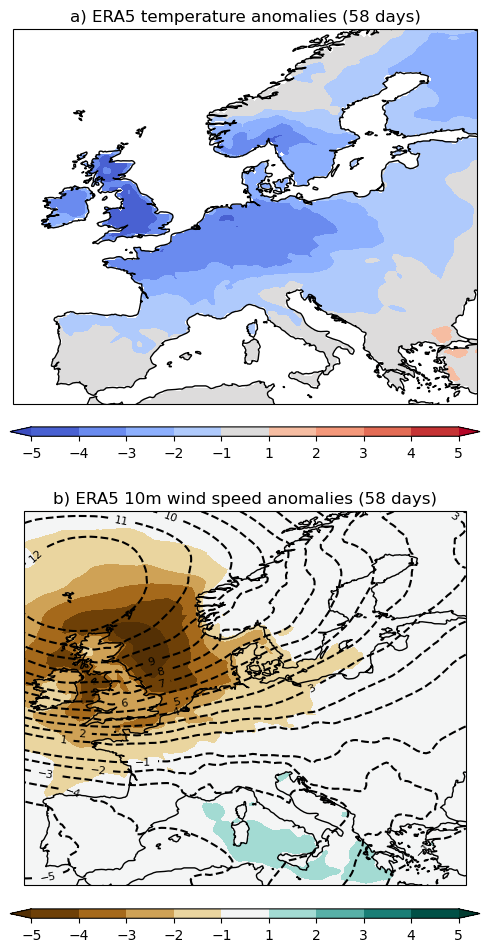

In [40]:
# ---------------------------------
# Plot the figure
# ---------------------------------

from mpl_toolkits.axes_grid1 import make_axes_locatable

# Set up a figure with 2 rows and 1 column
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5, 10), subplot_kw={"projection": ccrs.PlateCarree()})

# Plot the temperature anomalies
ax1 = axs[0]

# Set u the map
mymap1 = ax1.contourf(
    temp_anomalies.coord("longitude").points,
    temp_anomalies.coord("latitude").points,
    temp_anoms_arr_masked,
    cmap="coolwarm",
    tranform=ccrs.PlateCarree(),
    levels=temp_clevs,
    extend="both",
)

ax1.coastlines()

# Set up the title
ax1.set_title(f"a) ERA5 temperature anomalies ({num_days} days)")

# Include a cbar to the side
cbar1 = plt.colorbar(mymap1, ax=ax1, orientation="horizontal", pad=0.05, aspect=50)

# # Create a divider for the existing axes instance
# divider = make_axes_locatable(ax1)

# # Append axes to the right of ax1, with 5% width of ax1
# cax = divider.append_axes("right", size="5%", pad=0.05)

# # Create the colorbar in the new axes
# cbar1 = plt.colorbar(mymap1, cax=cax)

# # plot only the land data
# ax1.add_feature(cartopy.feature.LAND, edgecolor="black")

# Plot the wind anomalies
ax2 = axs[1]

# Set u the map
mymap2 = ax2.contourf(
    wind_anomalies.coord("longitude").points,
    wind_anomalies.coord("latitude").points,
    wind_anoms_arr,
    cmap="BrBG",
    tranform=ccrs.PlateCarree(),
    levels=wind_clevs,
    extend="both",
)

# Superimpose the psl anomaly contours
psl_contour = ax2.contour(
    psl_anomalies.coord("longitude").points,
    psl_anomalies.coord("latitude").points,
    psl_anoms_arr / 100,
    levels=psl_levels,
    colors="black",
    linestyles="dashed",
    transform=ccrs.PlateCarree(),
)

# set labels for the contours
ax2.clabel(psl_contour, inline=True, fontsize=8)

ax2.coastlines()

# Include a cbar to the side
cbar2 = plt.colorbar(mymap2, ax=ax2, orientation="horizontal", pad=0.05, aspect=50)

# Set up the title
ax2.set_title(f"b) ERA5 10m wind speed anomalies ({num_days} days)")

# Set up a tight layout
plt.tight_layout()